# Análisis de datos y uso de CatBoost para la predicción de clientes solicitantes de un deposito a plazo fijo                          

## Contenido

#### 1. Introducción

    * Identificación del problema
    * ¿Que es un deposito a plazo fijo?
    * Objetivos
    
#### 2. Importación de librerías y carga de datos

    
#### 3. Exploración de los datos

    * Eliminación y cambio de tipo de variables   
    
#### 4. Preprocesamiento de datos

    * Identificación de outliers
    * Imputación de outliers
    * Identificación de valores faltantes
       
#### 5. Análisis y visualización de datos

    * Análisis univariado
    * Análisis bivariado
    * Correlación de Pearson
    * V de Cramer

#### 6. Transformación de datos

    * Codificación de variables
    * Creación de conjuntos de entrenamiento y validación
    * Rebalanceo de datos

#### 7. Construcción y evaluación del modelo predictivo

    * Elección de hiperparámetros
        * Hiperparámetros para datos con outliers y sin codificación manual
        * Hiperparámetros para datos con outliers y con codificación manual
        * Hiperparámetros para datos sin outliers y sin codificación manual
        * Hiperparámetros para datos sin outliers y con codificación manual
    * Elección del mejor modelo
    * Interpretación del modelo
    
#### 8. Conclusiones

---

## 1. Introducción

### Identificación del problema

Uno de los usos más populares de la ciencia de datos es en el sector del marketing, puesto que es una herramienta muy poderosa que ayuda a las empresas a predecir de cierta forma el resultado de una campaña de marketing en base a experiencias pasadas, y que factores serán fundamentales para su éxito o fracaso. A la vez que también ayuda a conocer los perfiles de las personas que tienen más probabilidad de convertirse en futuros clientes con el fin de desarrollar estrategias personalizadas que puedan captar de forma más efectiva su interés. Conocer de antemano o a posteriori esta información es de vital importancia ya que ayuda en gran medida a que la empresa pueda conocer más acerca del público al que se tiene que enfocar, y que en el futuro se puedan desarrollar campañas de marketing que resulten más efectivas y eficientes. Entonces, se identifica que la problemática a tratar es el entender los factores que influyen a que una persona solicite o no un depósito a plazo fijo ofrecido por un determinado banco y predecir dado una serie de características, que personas solicitarán o no dicho servicio. Para ello, se requiere analizar la última campaña de marketing ejecutada por el banco y algunas características de sus clientes, con el fin de identificar patrones que nos puedan ayudar a comprender y encontrar soluciones para que el banco pueda desarrollar estrategias efectivas que les ayuden a captar el interés de las personas en solicitar este tipo de depósito, y en base a esto, construir un modelo predictivo que permita predecir que personas tomaran este servicio o no.

### ¿Qué es un depósito a plazo fijo?

Es una inversión que consiste en el depósito de una cantidad determinada de dinero a una institución financiera por un periodo de tiempo, en donde el cliente no puede retirar el dinero depositado hasta que este periodo de tiempo haya finalizado. La ventaja de este tipo de depósito es que permite ahorrar dinero ganando intereses, por lo cual, muchas personas lo ven como una forma efectiva de generar ingresos pasivos.

### Objetivos

* Realizar análisis de datos para encontrar y entender los factores que influyen a que una persona solicite o no un depósito a plazo fijo.
* Construir un modelo de aprendizaje automático con CatBoost para la predicción de solicitantes de un depósito a plazo fijo.
* Implementar correctamente cada uno de los pasos de la metodología de ciencia de datos en la elaboración de este proyecto

---

## 2. Importación de librerías y carga de datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import FormatStrFormatter
import association_metrics as am
from collections import Counter
from catboost import CatBoostClassifier, Pool
import optuna  
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

El conjunto de datos con el que vamos a tratar almacena características de 11162 personas a los que un banco contactó para ofrecerles el servicio de depósito a plazo fijo, e indica si estos al final decidieron solicitar dicho depósito o no.

In [2]:
data = pd.read_csv("Bank_Marketing.csv")

---

## 3. Exploración de los datos

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
data.shape

(11162, 17)

In [5]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Podemos extraer algunos insights simples de esta tabla, como que el promedio de edad de los clientes de la empresa ronda en los 41 años. También que el saldo promedio que tienen en su cuenta es de 1528, pero si observamos la desviación estándar de los datos de esta variable, observamos que tiene un valor 3225, el cual es considerablemente alto, por lo que podemos decir que el saldo de los clientes está muy distribuido en nuestro conjunto de datos, presentando una alta variación. Por último, podemos observar que la variable pdays (número de días después del último contacto en la campaña anterior del banco) tiene un valor mínimo de -1, lo cual al momento de la interpretabilidad en el análisis de datos puede resultar algo confuso, es por ello que en la sección del preprocesamiento de datos se procederá a reemplazar este valor por un 0.

### Eliminación y cambio de tipo de variables

Hay que tener en cuenta algo de suma importancia en nuestros datos, y es que la variable "duration" hace referencia al tiempo de duración en segundos del último contacto que se realizó con la persona antes que decidiera solicitar o no un depósito a plazo fijo, y como naturalmente este valor no se conoce hasta después de haber realizado la llamada que es cuando ya se sabe la decisión de la persona, se procederá a eliminar al momento de construir nuestro modelo predictivo, puesto que estaría otorgando información que de por si no se conoce de antemano.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Observamos que aparentemente todas nuestras variables de entrada parecen tener cierta relación con la decisión de una persona en solicitar o no un depósito a plazo fijo, por lo que se decide por el momento no eliminar ninguna de estas variables de forma injustificada.

También observamos que todas las variables de nuestro conjunto de datos están correctamente etiquetadas con el tipo de dato que les corresponde, por lo tanto, no se requiere realizar conversión alguna.

---

## 4. Preprocesamiento de datos

Como habíamos explicado en la sección anterior, procederemos a reemplazar los valores iguales a -1 por 0 en la variable pdays.

In [7]:
for i in range(0,data.shape[0]):
    if data["pdays"].iloc[i] == -1:
        data["pdays"].iloc[i] = 0

Entonces, si ahora observamos el valor mínimo de la variable pdays obtendremos un 0 como resultado en vez de un -1.

In [8]:
data["pdays"].min()

0

### Identificación de outliers

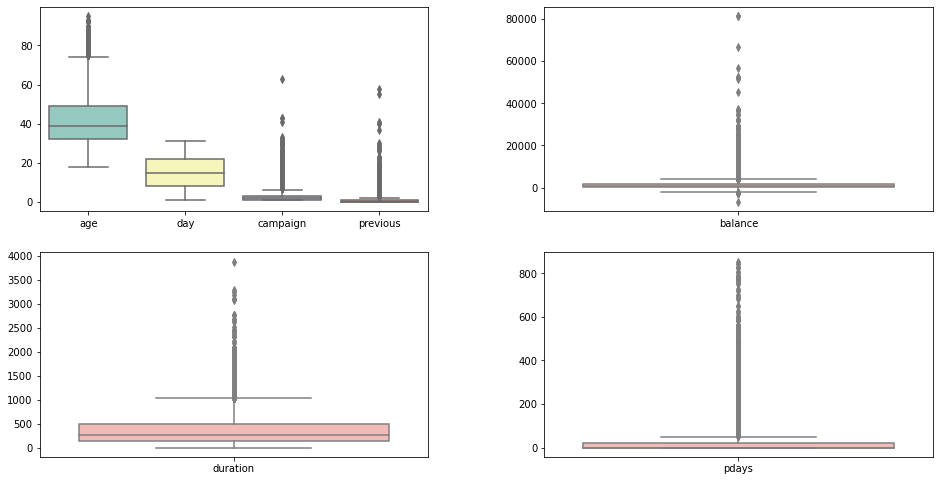

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))
plt.subplots_adjust(wspace=0.3, top=0.75)
sns.boxplot(ax=ax[0][0], data= data[["age", "day", "campaign", "previous"]], palette="Set3")
sns.boxplot(ax=ax[0][1], data= data[["balance"]], palette="Pastel1")
sns.boxplot(ax=ax[1][0], data= data[["duration"]], palette="Pastel1")
sns.boxplot(ax=ax[1][1], data= data[["pdays"]], palette="Pastel1")
plt.show()

Con el diagrama de cajas observamos que tenemos presencia de outliers en todas nuestras variables numéricas excepto en la variable "day".

A continuación, visualizaremos el porcentaje de outliers con respecto al total en cada una de nuestras variables para poder considerar si debemos tomar la decisión de eliminar alguna de estas variables por su alta presencia de valores atípicos.

In [10]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

In [11]:
( (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)) ).sum() / data.shape[0] * 100

age           1.531984
balance       9.451711
campaign      5.384340
contact       0.000000
day           0.000000
default       0.000000
deposit       0.000000
duration      5.697904
education     0.000000
housing       0.000000
job           0.000000
loan          0.000000
marital       0.000000
month         0.000000
pdays        24.672998
poutcome      0.000000
previous     11.270382
dtype: float64

Los resultados nos arrojan que la variable "pdays" tiene un 24% de presencia de outliers respecto al total de filas, lo cual siguiendo la buena práctica de eliminar aquellas variables que superen un umbral del 15% de valores atípicos, procederemos a eliminar esta variable ya que puede inferir de forma negativa en el análisis y la predicción del futuro modelo de clasificación que se construirá. Otro dato a tomar en cuenta, es que esta variable es la misma que presentaba valores iguales a -1, los cuales reemplazamos con 0, donde quizá los valores etiquetados como -1 se debieron a una corrupción en los datos, con lo cual tenemos un motivo más para eliminar esta variable.

In [12]:
data = data.drop(["pdays"], axis=1)

#### Age

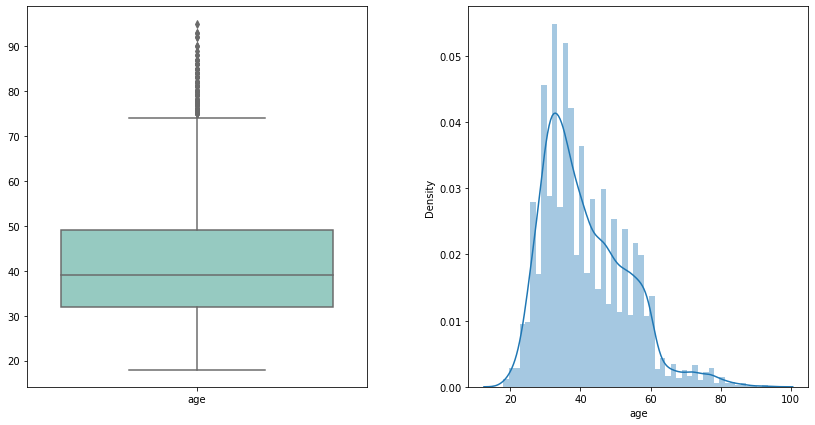

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["age"]], palette="Set3")
sns.distplot(data["age"], ax=ax[1])
plt.show()

De los siguientes gráficos podemos observar que los datos que son catalogados como atípicos según el rango intercuartílico son personas que superan los 75 años de edad sin llegar a pasar los 95 años. Este rango de edad no es ningún error o corrupción en los datos, ya que la mayoría de personas con una calidad de vida adecuada podrían alcanzar este rango, por lo tanto, tenemos dos opciones para tratarlos:
* Eliminar las filas que contengan estas edades debido a que su presencia es tan solo del 1.5% del total.
* Imputarlos haciendo uso de un algoritmo predictivo.

Todos estos métodos resultan aceptables, pero en este caso optaremos por imputarlos por un valor aproximado a lo "normal" que refleje la misma conducta que el valor atípico, más que todo para no perder información. De igual forma, al momento del entrenamiento y la elección del mejor modelo de clasificación, se comparará el rendimiento de un modelo libre de outliers con uno con outliers con el fin de observar si nuestra decisión fue acertada.

#### Campaign

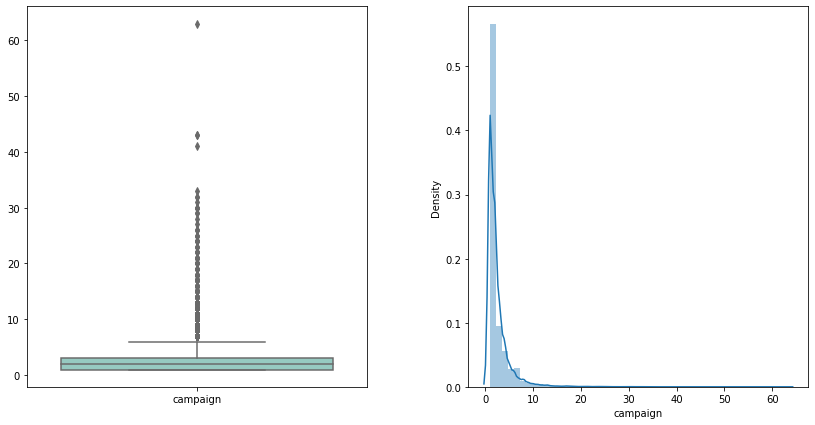

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["campaign"]], palette="Set3")
sns.distplot(data["campaign"], ax=ax[1])
plt.show()

Con respecto a esta variable, observamos que la inmensa mayoría de nuestros datos tienen un valor entre 1 y 5, mientras que los datos atípicos adquieren valores superiores a este rango. Evidentemente este es un comportamiento inusual ya que, según nuestros datos, comúnmente solo se realizan entre 1 y 5 contactos con el cliente antes de que este tome una decisión final, por ende, números de contactos iguales a 10, 20, 30 e incluso mayores a 40 son demasiado extraños de ver. Por ende, procederemos a imputar estos valores por estimaciones que se aproximen a un valor común.

#### Previous

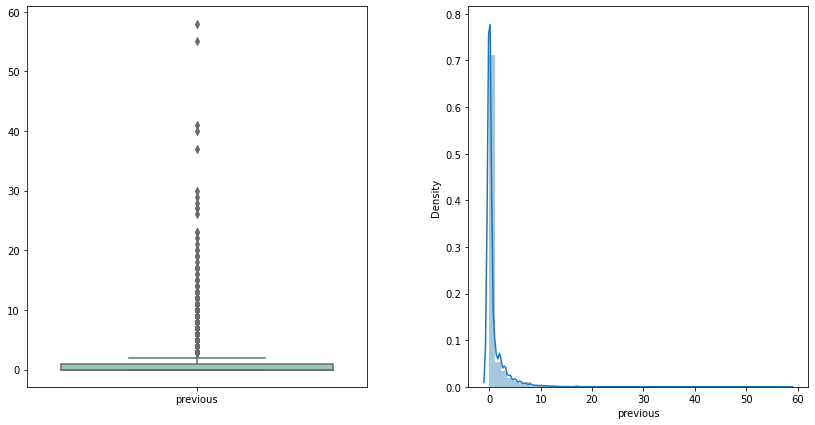

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["previous"]], palette="Set3")
sns.distplot(data["previous"], ax=ax[1])
plt.show()

Al igual que en la variable "campaign", "previous" aparte de tener una definición similar (número de contactos con el cliente en la campaña anterior), este también presenta un comportamiento similar, en donde se observa que los valores comunes están en un rango entre 0 y 3, y que los datos considerados como atípicos toman valores superiores a este rango, llegando incluso a ser excesivos. Es por ello que se tomara la misma decisión de imputarlos al igual que "campaign".

#### Balance

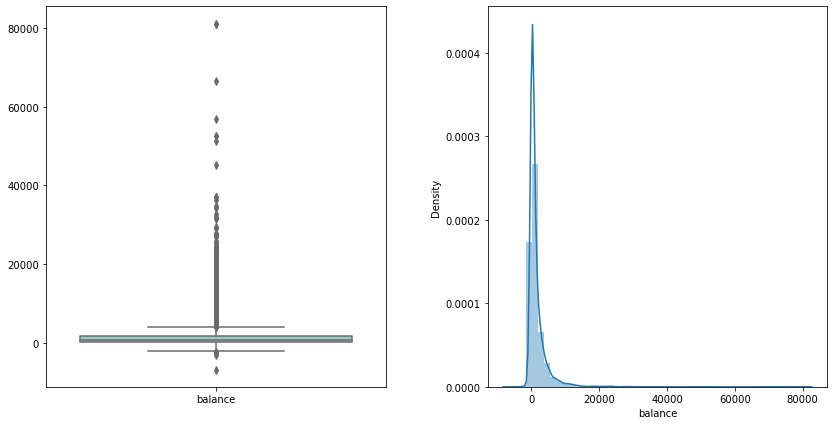

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["balance"]], palette="Set3")
sns.distplot(data["balance"], ax=ax[1])
plt.show()

Un comportamiento similar a las anteriores gráficas observamos en esta variable, donde nuevamente tenemos un sesgo por la derecha en donde los datos comunes adquieren valores entre -300 y 4000, y los que son atípicos llegan a superar fácilmente este umbral, aunque resulta más común que lo superen en forma positiva que en forma negativa, lo cual podemos deducir que, en términos de valores atípicos, es más común encontrar datos anormalmente altos que datos anormalmente bajos. Debido a que el porcentaje de datos atípicos para esta variable es del 9.4%, el cual no es un valor ni muy grande ni muy pequeño, no conviene eliminarlos, es por ello que los imputaremos por un nuevo valor aproximado que entre en un rango más común.

#### Duration

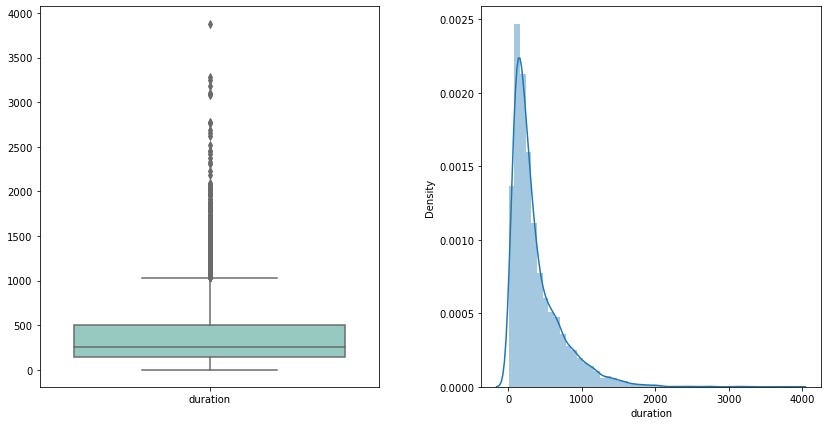

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data[["duration"]], palette="Set3")
sns.distplot(data["duration"], ax=ax[1])
plt.show()

Esta variable también presenta un sesgo notorio por la derecha al igual que las variables anteriores, con la diferencia que su distribución parece ser más equitativa respecto a las demás, aquí podemos apreciar que los valores comunes están en un rango entre 0 y 1000 segundos (16 minutos aprox.) y que los que son considerados atípicos superan fácilmente este rango, llegando incluso a ser superiores a los 3000 segundos (50 minutos). Observar que una llamada entre un empleado del banco y un cliente supere los 30 minutos es un comportamiento inusual y que no se acostumbra a tener, es por ello que estos datos deben ser tratados, y para este caso haremos uso de la imputación iterativa aplicando bosques aleatorios para reemplazar dichos valores por unos que se acerquen a un comportamiento común de observar.

### Imputación de outliers

Crearemos una copia del conjunto de datos original con el fin de que mas adelante podamos comparar el rendimiento de nuestro modelo predictivo en ambos conjuntos (datos con outliers y sin outliers).

In [18]:
data2 = data.copy()

El primer paso para realizar la imputación será convertir todos los valores atípicos que se hayan detectado mediante el rango intercuartílico por NaN, ya que la función que utilizaremos para la imputación trabaja con este tipo de datos.

In [19]:
outliers = (data2 < (Q1 - 1.5 * IQR)) | (data2 > (Q3 + 1.5 * IQR))
data2[outliers] = np.nan

Ahora tenemos que aplicar una codificación para nuestras variables categóricas, debido a que usaremos bosques aleatorios como medio de imputación, bastara con aplicar un label encoder.

In [20]:
# Nombres de nuestras variables categóricas
cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome", "deposit"]

# Diccionario para almacenar la codificación realizada en cada variable (Útil para después revertir la transformación)
dic = {}

for col in cols:
    dic[col] = LabelEncoder().fit(data2[col])
    data2[col] = dic[col].transform(data2[col])

El siguiente paso ahora es dividir nuestros datos en conjuntos de entrenamiento y prueba con el fin de evitar la fuga de datos.

In [21]:
# Guardamos los nombres de las columnas de nuestro Dataset (Útil para después concatenar estos conjuntos en uno solo)
nom_cols = data2.columns.values

X = data2.iloc[: , :-1].values
y = data2.iloc[: , -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21, stratify=y)

Finalmente, procederemos a realizar la imputación.

In [22]:
imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=21), random_state=21)
X_train = imputer.fit_transform(X_train)

In [23]:
X_test = imputer.transform(X_test)

Para visualizar el resultado de nuestra imputación de forma cómoda y gráfica, será necesario concatenar todos los subconjuntos que hemos creado en uno solo como teníamos inicialmente y revertir la codificación de nuestras variables categóricas.

In [24]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

data2 = pd.concat([X, y], axis=1)

data2.columns = nom_cols  # Se les introduce los nombres de las columnas con la variable anteriormente creada

# Se invierte la codificación
for col in cols:
    data2[col] = dic[col].inverse_transform(data2[col].astype(int))

Debido a que las predicciones hechas por los bosques aleatorios se basan en el promedio del resultado de varios árboles de decisión, tendremos algunos datos imputados como decimal en variables que son enteras, como en el caso de "age", es por ello que redondearemos dichos valores decimales en cada variable que solo contenga valores enteros.

In [25]:
for col in ["age", "day", "campaign", "previous", "balance", "duration"]:
    data2[col] = data2[col].round()

Ahora si podemos graficar para observar el cambio en nuestros datos después de la imputación.

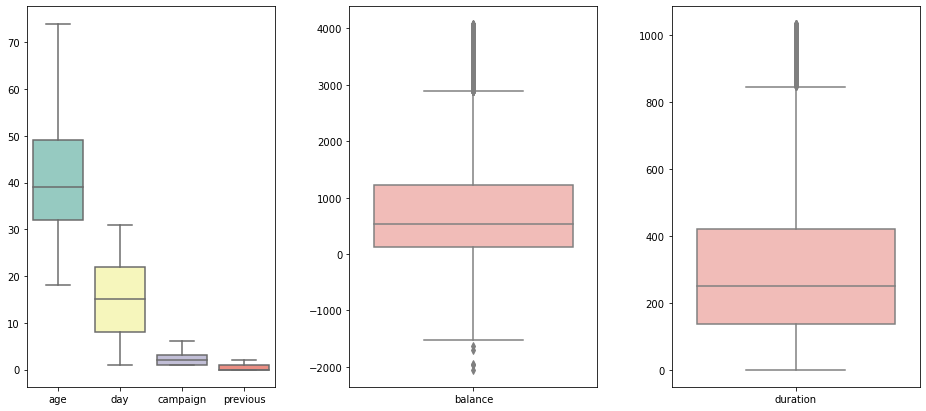

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(16,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data2[["age", "day", "campaign", "previous"]], palette="Set3")
sns.boxplot(ax=ax[1], data= data2[["balance"]], palette="Pastel1")
sns.boxplot(ax=ax[2], data= data2[["duration"]], palette="Pastel1")
plt.show()

Del grafico podemos observar que todas las variables a excepción de "balance" y "duration" están libres de outliers.

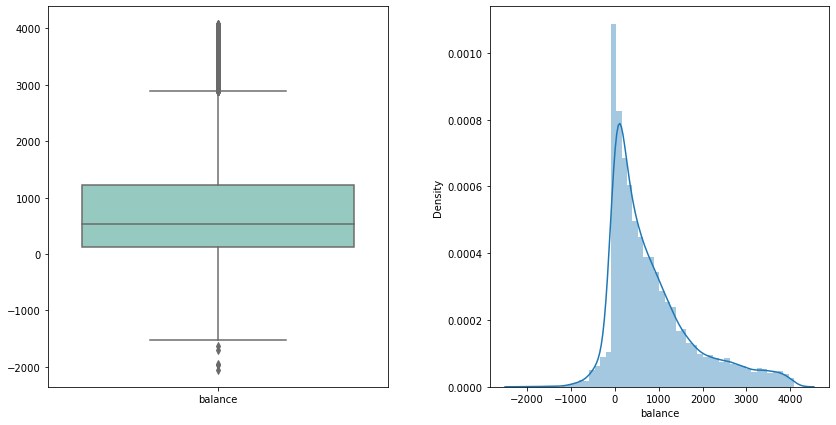

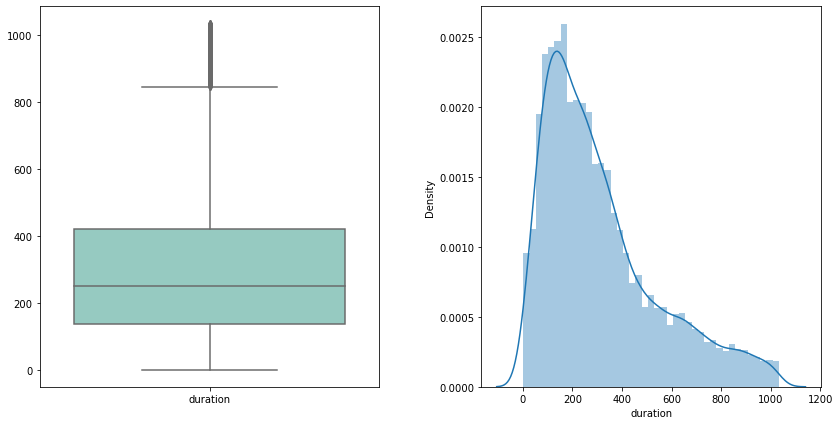

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data2[["balance"]], palette="Set3")
sns.distplot(data2["balance"], ax=ax[1])

fig, ax = plt.subplots(1, 2, figsize=(14,7))
plt.subplots_adjust(wspace=0.3)
sns.boxplot(ax=ax[0], data= data2[["duration"]], palette="Set3")
sns.distplot(data2["duration"], ax=ax[1])

plt.show()

Analizando las variables que aún tienen presencia de valores atípicos, se ve que la varianza en la distribución de estos valores ya no es tan extrema como teníamos inicialmente, si no que ahora se distribuyen en un rango menor a 1000 unidades, incluso pudiéndose acercar a una distribución normal.

In [28]:
Q1 = data2.quantile(0.25)
Q3 = data2.quantile(0.75)
IQR = Q3 - Q1

In [29]:
( (data2 < (Q1 - 1.5 * IQR)) | (data2 > (Q3 + 1.5 * IQR)) ).sum() / data2.shape[0] * 100

age          0.000000
balance      5.644150
campaign     0.000000
contact      0.000000
day          0.000000
default      0.000000
deposit      0.000000
duration     4.139043
education    0.000000
housing      0.000000
job          0.000000
loan         0.000000
marital      0.000000
month        0.000000
poutcome     0.000000
previous     0.000000
dtype: float64

A la vez que también observamos que estos datos atípicos solo constituyen el 5.6% y 4.1% respectivamente del total, lo cual es una cifra moderadamente baja. Entonces podemos tomar dos decisiones, eliminarlos o conservarlos como parte de nuestros datos. En esta ocasión, elegiré conservarlos ya que pueden contener información útil para el análisis y para el modelo de clasificación, además que su presencia es relativamente baja con respecto del total y su distancia de los extremos no es tan alarmante ni exagerada.

### Identificación de valores faltantes

Observamos cuantos valores faltantes hay en nuestro conjunto de datos.

In [30]:
data2.isnull().sum().sum()

0

Debido a que no hay presencia de valores faltantes o nulos, no será necesario tomar acciones al respecto.

---

## 5. Análisis y visualización de datos

En base a las variables que tenemos disponibles, empezaremos la sección formulando algunas hipótesis que seran respondidas mediante el proceso de análisis de los datos.

* H1: ¿Es la edad del cliente un factor que propicie la solicitud de un depósito a plazo fijo?
* H2: ¿Qué tipo de trabajos son más propensos a tener clientes que quieran solicitar un depósito a plazo fijo?
* H3: ¿Los clientes casados son menos propensos a solicitar un depósito a plazo fijo?
* H4: ¿El grado de educación alcanzado por el cliente propicia a la solicitud de un depósito a plazo fijo?
* H5: ¿Los clientes con mora crediticia en el banco son menos propensos a solicitar un depósito a plazo fijo?
* H6: ¿Se puede decir que los clientes con mayor dinero en su cuenta bancaria son muy propensos a solicitar un depósito a plazo fijo?
* H7: ¿Los clientes con un préstamo para vivienda en el banco son menos propensos a solicitar un depósito a plazo fijo?
* H8: ¿Los clientes con un préstamo personal en el banco son menos propensos a solicitar un depósito a plazo fijo?
* H9: ¿El medio de comunicación con el que se contacta al cliente afecta en la solicitud de un depósito a plazo fijo?
* H10: ¿Existen días específicos en los que sea más probable convencer a un cliente de solicitar un depósito a plazo fijo?
* H11: ¿Existen meses específicos en los que sea más probable convencer a un cliente de solicitar un depósito a plazo fijo?
* H12: ¿Se puede decir que a mayor duración en tiempo de contacto con el cliente aumentan las posibilidades de que este acepte solicitar un depósito a plazo fijo?
* H13: ¿Es cierto que mientras más contactos se tenga con el cliente mayor será la posibilidad de que este termine aceptando solicitar un depósito a plazo fijo?
* H14: ¿El número de contactos realizados en la campaña anterior afecta en la posibilidad de que los clientes soliciten un depósito a plazo fijo?
* H15: ¿Los clientes que solicitaron un depósito a plazo fijo en la campaña anterior son más propensos a solicitar el mismo servicio en la campaña actual?

### Análisis univariado

Para comenzar, visualizaremos la distribución de los datos respecto a cada uno de los tres conjuntos de variables que se han identificado: Variables de información del cliente - Variables de información bancaria - Variables de campaña. Esta segmentación nos permitirá realizar un análisis más ordenado e identificar patrones e información útil para entender nuestros datos.

#### Variables de información del cliente

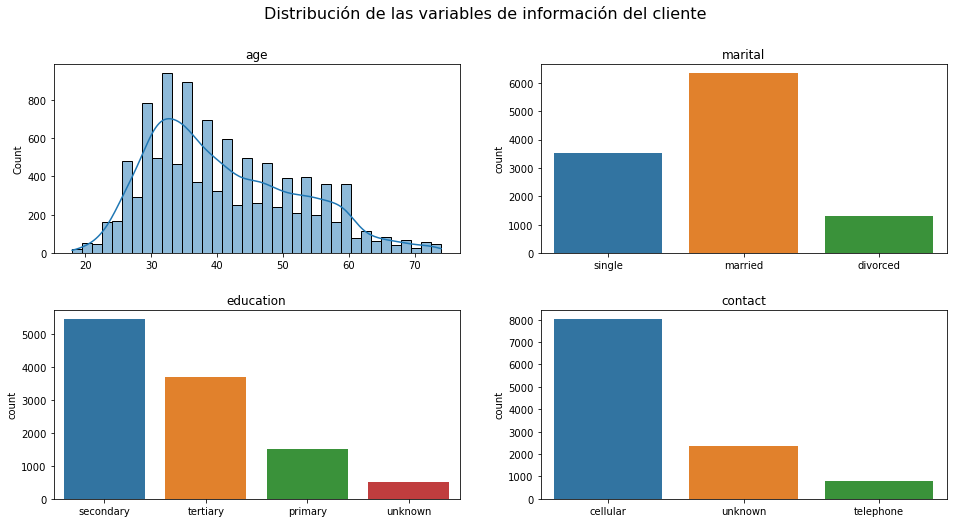

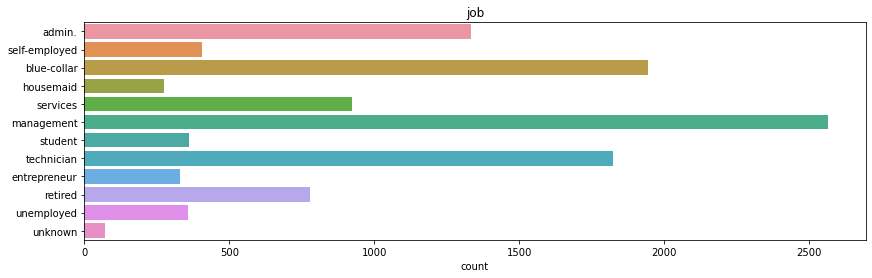

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.histplot(data=data2, x="age", kde=True, ax=ax[0,0])
ax[0,0].set_title("age")
ax[0,0].set_xlabel("")
sns.countplot(data=data2, x="marital", ax=ax[0,1])
ax[0,1].set_title("marital")
ax[0,1].set_xlabel("")
sns.countplot(data=data2, x="education", ax=ax[1,0])
ax[1,0].set_title("education")
ax[1,0].set_xlabel("")
sns.countplot(data=data2, x="contact", ax=ax[1,1])
ax[1,1].set_title("contact")
ax[1,1].set_xlabel("")
fig.suptitle("Distribución de las variables de información del cliente", fontsize=16)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
sns.countplot(data=data2, y="job")
ax.set_title("job")
ax.set_ylabel("")
plt.show()

Observamos que la mayoría de clientes del banco tienen edades que entran en el rango de los 30 y 40 años, sin embargo, la diferencia entre el número de clientes que entran en este rango y los que no, no es muy grande. Entonces podemos decir que el banco en su gran mayoría tiene clientes que no sobrepasan la mediana edad.

También podemos observar que la mayoría de estas personas son casadas y que muy pocas son divorciadas. Y que el tipo de educación predominante es la secundaria y terciaria.

Por otra parte, se aprecia que el medio de contacto preferido por los clientes es el celular, y que la mayoría de clientes del banco tienen puestos de gerencia, obrero y técnico. Y muy pocos son amas de casa, emprendedores o desempleados.

#### Variables de información bancaria

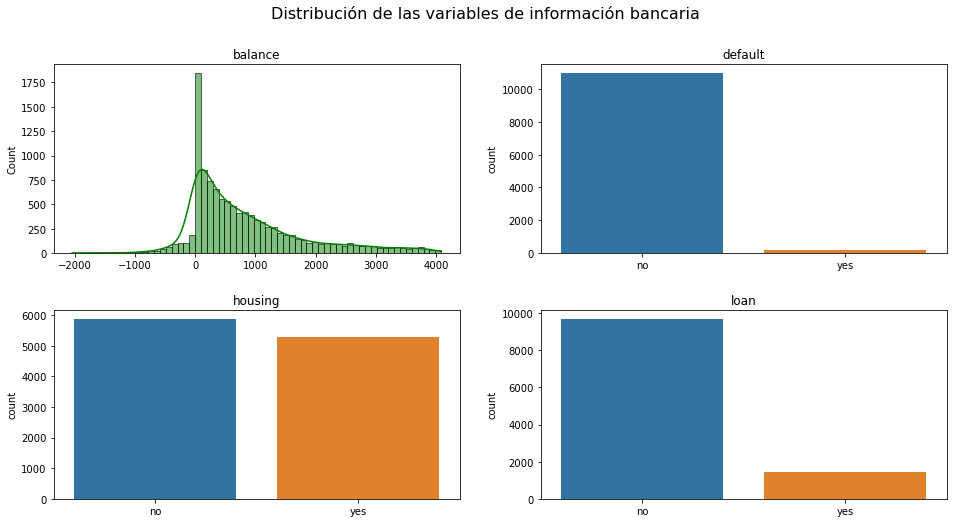

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.histplot(data=data2, x="balance", kde=True, ax=ax[0,0], color="g")
ax[0,0].set_title("balance")
ax[0,0].set_xlabel("")
sns.countplot(data=data2, x="default", ax=ax[0,1])
ax[0,1].set_title("default")
ax[0,1].set_xlabel("")
sns.countplot(data=data2, x="housing", ax=ax[1,0])
ax[1,0].set_title("housing")
ax[1,0].set_xlabel("")
sns.countplot(data=data2, x="loan", ax=ax[1,1])
ax[1,1].set_title("loan")
ax[1,1].set_xlabel("")
fig.suptitle("Distribución de las variables de información bancaria", fontsize=16)
plt.show()

Con respecto a la variable "balance" (saldo del cliente en su cuenta bancaria) observamos que existen muchos clientes que tienen relativamente poco dinero acumulado en sus cuentas, estos valores se encuentran en un rango mayor a 0 y menor a 1000.

También podemos observar que casi no existen clientes morosos en el banco, esta variable se podría relacionar con "balance", en donde se observa que hay muy pocas personas con saldo negativo en sus cuentas bancarias.

Por otro lado, tenemos que la cantidad de clientes que han solicitado un préstamo para vivienda es muy similar a la cantidad de clientes que no solicitaron dicho préstamo.

Por último, observamos que la gran mayoría de clientes no han solicitado un préstamo personal, y los que si lo han hecho, debido a que son minoría, podrían relacionarse con la poca presencia de clientes deudores en la variable "default" y la poca presencia de clientes con saldo negativo en la variable "balance".

#### Variables de campaña

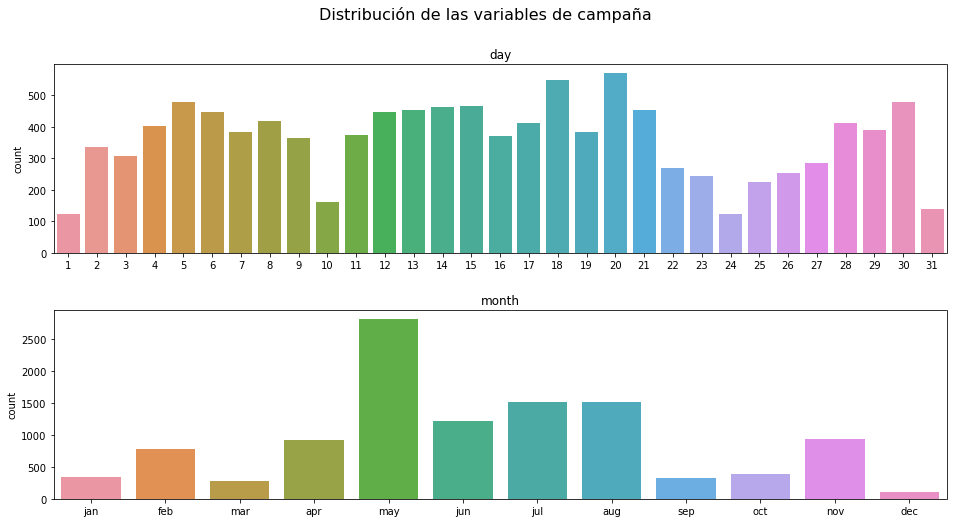

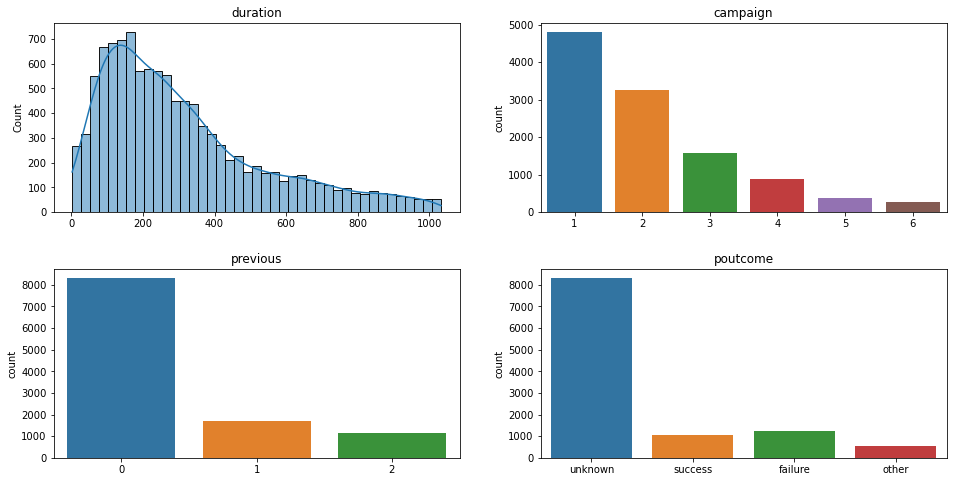

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.countplot(data=data2, x="day", ax=ax[0])
ax[0].set_title("day")
ax[0].set_xlabel("")
ax[0].set_xticklabels(range(1,32))
sns.countplot(data=data2, x="month", ax=ax[1], order=["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct",
                                                      "nov", "dec"])
ax[1].set_title("month")
ax[1].set_xlabel("")
fig.suptitle('Distribución de las variables de campaña', fontsize=16)
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.histplot(data=data2, x="duration", kde=True, ax=ax[0,0])
ax[0,0].set_title("duration")
ax[0,0].set_xlabel("")
sns.countplot(data=data2, x="campaign", ax=ax[0,1])
ax[0,1].set_title("campaign")
ax[0,1].set_xlabel("")
ax[0,1].set_xticklabels(range(1,7))
sns.countplot(data=data2, x="previous", ax=ax[1,0])
ax[1,0].set_title("previous")
ax[1,0].set_xlabel("")
ax[1,0].set_xticklabels(range(0,3))
sns.countplot(data=data2, x="poutcome", ax=ax[1,1])
ax[1,1].set_title("poutcome")
ax[1,1].set_xlabel("")
plt.show()

Observamos que la cantidad de veces con respecto a los días en los que se contacta al cliente por última vez están distribuidos de forma casi equitativa, en donde solo se observan picos muy bajos en los días 1, 10, 24 y 31 de cada mes, y los picos más altos son los que se acercan a principio, quincena o final de cada mes. Esto se debe probablemente a que estos días son previos al pago que reciben los clientes en su trabajo, por ende, se intenta aprovechar el ingreso de dinero que tienen esos días para ofrecerles métodos de inversión de dinero como el depósito a plazo fijo.

Con respecto al mes en el que se realizó el último contacto, se observa que Mayo es un mes con mucha importancia para realizar contacto con los clientes, esto podría deberse a que los datos que estamos analizando provienen de un banco en Portugal, y dicho país celebra en este mes el día del trabajo, por lo tanto se puede suponer que todos los trabajadores en dicho país reciben un incentivo económico y el banco aprovecha esta situación para que el dinero recibido por sus clientes se invierta en la empresa.

Por otro lado, respecto a la duración del último contacto en segundos, podemos ver que la gran mayoría de estos tuvo una duración entorno a los 100 y 300 segundos (1.6 y 3.3 minutos respectivamente), lo cual es un tiempo justo para saber la decisión final del cliente.

El número de contactos realizados en esta campaña son en su gran mayoría 1 o 2. Y el número de contactos realizados en la anterior campaña está muy inclinado al 0, por lo tanto, se puede deducir que el banco tiene nuevos clientes o que la campaña anterior no fue ejecutada de forma adecuada.

Por último, respecto a la variable "poutcome" (resultado de la campaña anterior) podemos observar que una inmensa mayoría de clientes están etiquetados como "unknown" (desconocido), lo cual respalda la suposición que anteriormente habíamos hecho respecto a que el banco tenía nuevo clientes, debido a que esta variable guarda relación con "previous".

Una vez conocida la distribución de las variables con las que vamos a trabajar, procederemos a responder las hipótesis que inicialmente habíamos planteado, esto lo lograremos mediante un análisis bivariado de nuestras variables de entrada con nuestra variable de salida.

### Análisis bivariado

#### Variables de infomación del cliente vs "deposit"

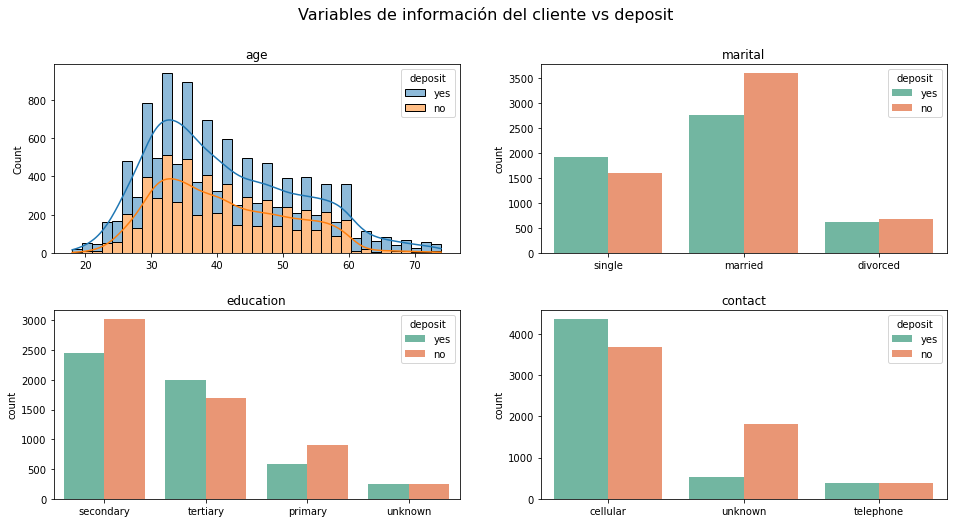

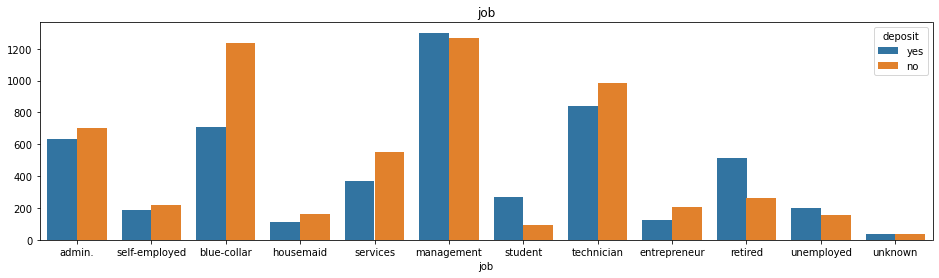

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(hspace=0.3)
sns.histplot(data=data2, x="age", kde=True, ax=ax[0,0], hue=data2.deposit, multiple="stack")
ax[0,0].set_title("age")
ax[0,0].set_xlabel("")
sns.countplot(data=data2, x="marital", ax=ax[0,1], hue=data2.deposit, palette="Set2")
ax[0,1].set_title("marital")
ax[0,1].set_xlabel("")
sns.countplot(data=data2, x="education", ax=ax[1,0], hue=data2.deposit, palette="Set2")
ax[1,0].set_title("education")
ax[1,0].set_xlabel("")
sns.countplot(data=data2, x="contact", ax=ax[1,1], hue=data2.deposit, palette="Set2")
ax[1,1].set_title("contact")
ax[1,1].set_xlabel("")
fig.suptitle('Variables de información del cliente vs deposit', fontsize=16)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.countplot(data=data2, x="job", hue=data2.deposit)
ax.set_title("job")
ax.set_ylabel("")
plt.show()

* En primer lugar, mediante el histograma observamos que la curva de densidad de las edades de los clientes que solicitaron y no solicitaron el depósito son muy similares, obteniendo en ambos casos los picos más altos en edades que entran en el rango de los 30 y 40 años, y que estos picos se diferencian por relativamente pocas cifras de las demás edades. Es decir, no existe un patrón claro que indique de forma significativa que una edad en específico es más propensa a solicitar un depósito a plazo fijo o no.

* Por otro lado, podemos observar que la variable "marital" no presenta relación alguna con la solicitud de un depósito a plazo fijo, ya que la cantidad de clientes que solicitaron o no el depósito se reparten de forma equitativa entre los que son solteros, casados y divorciados

* El mismo comportamiento se puede apreciar en la variable "education", donde la cantidad de clientes solicitantes y no solicitantes son muy parecidas en todos los grados de educación.

* Con respecto a "contact", podemos identificar que los clientes con un medio de comunicación desconocido por el banco son menos propensos a solicitar un depósito a plazo fijo, esta información podría no ser tan relevante debido a que como el medio de comunicación es desconocido, estos datos podrían ir a cualquier de las dos categorías restantes, sesgando un poco el resultado del análisis.

* Por último, en la variable "job" podemos observar que los clientes con trabajo "blue-collar" (obrero) son menos propensos a solicitar un depósito a plazo fijo, probablemente por los pocos ingresos que se obtienen de esta labor. Por otra parte, observamos que los estudiantes (student) y los retirados (retired) son levemente más propensos a solicitar este tipo de depósito, posiblemente debido a la cultura financiera que existe en la mayoría de centros educativos y la alta disponibilidad de dinero que se tiene al haberse jubilado.

Resumiendo toda la información obtenida tenemos que: La edad de los clientes no es un factor muy influyente para determinar si estos van a solicitar un depósito a plazo fijo o no, además que tanto su estado marital como educacional tampoco influyen en esta decisión, sin embargo, se observa que los clientes con un medio de contacto desconocido por el banco son más propensos a no solicitar este tipo de depósito, a la vez que los que tienen trabajos relacionados con la mano de obra tienen una tendencia a tampoco solicitar este servicio, y las personas que son estudiantes o retiradas a menudo aceptan el depósito a plazo fijo.

Respondiendo a las hipótesis tenemos que:

* H1: La edad del cliente no afecta de forma significativa en la decisión de solicitar un depósito a plazo fijo.
* H2: Se observo que los estudiantes y las personas retiradas son ligeramente más propensas a solicitar un depósito a plazo fijo.
* H3: El estado marital del cliente no influye en la decisión de solicitar un depósito a plazo fijo.
* H4: El grado de educación alcanzado por el cliente no influye de forma significativa en la decisión de solicitar un depósito a plazo fijo.
* H9: Los clientes con un medio de contacto desconocido por el banco tienen ligeramente más probabilidad de no solicitar un depósito a plazo fijo.

#### Variables de información bancaria vs "deposit"

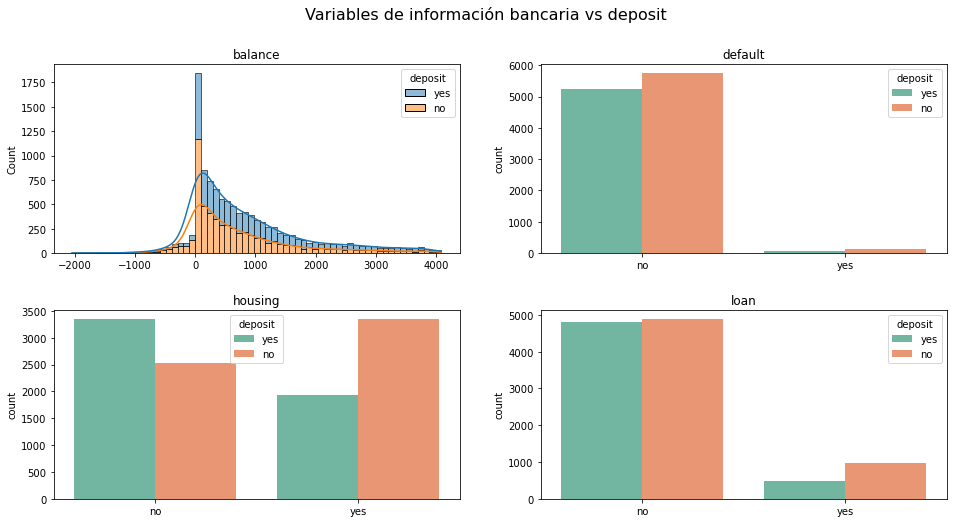

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(hspace=0.3)
sns.histplot(data=data2, x="balance", kde=True, ax=ax[0,0], hue=data2.deposit, multiple="stack")
ax[0,0].set_title("balance")
ax[0,0].set_xlabel("")
sns.countplot(data=data2, x="default", ax=ax[0,1], hue=data2.deposit, palette="Set2")
ax[0,1].set_title("default")
ax[0,1].set_xlabel("")
sns.countplot(data=data2, x="housing", ax=ax[1,0], hue=data2.deposit, palette="Set2")
ax[1,0].set_title("housing")
ax[1,0].set_xlabel("")
sns.countplot(data=data2, x="loan", ax=ax[1,1], hue=data2.deposit, palette="Set2")
ax[1,1].set_title("loan")
ax[1,1].set_xlabel("")
fig.suptitle('Variables de información bancaria vs deposit', fontsize=16)
plt.show()

* Del primer gráfico, mediante el histograma observamos que las curvas de densidad del saldo de los clientes en el banco son muy similares para los que solicitaron y no solicitaron el depósito a plazo fijo, siguiendo casi una distribución normal, no se observa algún patrón marcado que indique que un rango de saldo en específico propicie o no la solicitud de un depósito a plazo fijo.

* Con respecto a "default", tampoco se puede observar algún patrón especifico que indique que el ser un cliente moroso o no afecte en la decisión de solicitar o no un depósito a plazo fijo, ya que la distribución de estos se reparte de forma equitativa en ambas ocasiones.

* Con "housing" no podemos decir lo mismo, ya que aquí si se aprecia que los clientes que no solicitaron un préstamo de vivienda tienen una tendencia a solicitar un depósito a plazo fijo, mientras que los que si solicitaron un préstamo de vivienda tienen una tendencia a no solicitar este tipo de depósito. Esto podría deberse a que como ya tienen una deuda con el banco, ese dinero solicitado no puede destinarse a otros fines que no sea la adquisición de una propiedad.

* Por último, en la variable "loan" nuevamente no se observa un patrón claro que indique una inclinación hacia solicitar o no solicitar un depósito a plazo fijo si el cliente ha solicitado un préstamo personal o no.

Resumiendo toda la información obtenida tenemos que: El saldo de los clientes en sus cuentas bancarias no es un factor del que se pueda deducir si estos en un futuro solicitaran un depósito a plazo fijo o no, lo mismo podemos decir con respecto a si este cliente tiene mora crediticia o no, y si este solicito un préstamo personal o no. Sin embargo, observamos un patrón claro que indica que los clientes que solicitaron un préstamo de vivienda son menos propensos a solicitar un depósito a plazo fijo, probablemente porque ese dinero solicitado será destinado a otros fines.

Respondiendo a las hipótesis tenemos que:

* H5: El hecho de tener o no tener mora crediticia no influye en la decisión de solicitar o no un depósito a plazo fijo.
* H6: El dinero que los clientes tengan en su cuenta bancaria no influye en la decisión de solicitar o no un depósito a plazo fijo.
* H7: Los clientes que solicitaron un préstamo de vivienda al banco son menos propensos a solicitar un depósito a plazo fijo.
* H8: El hecho de solicitar o no un préstamo personal al banco no influye de forma significativa en la decisión de solicitar o no un depósito a plazo fijo.

#### Variables de campaña vs "deposit"

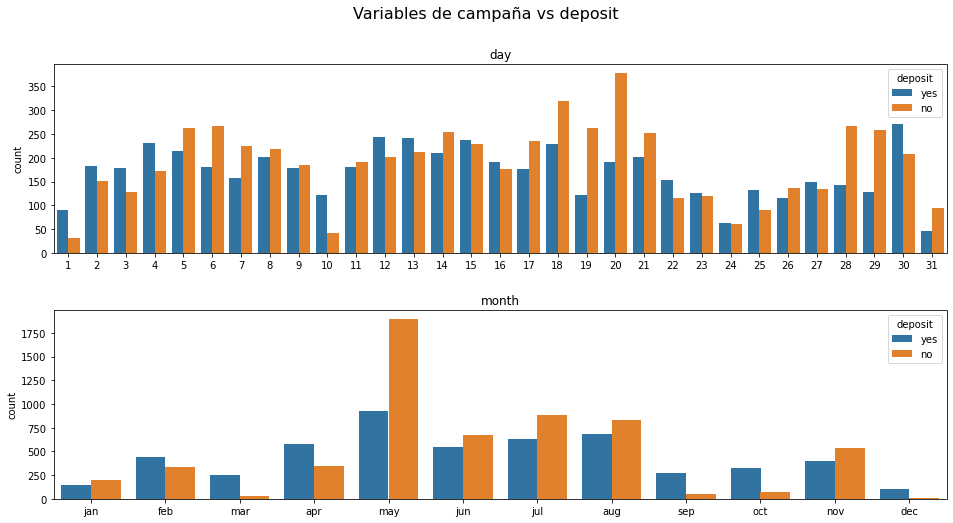

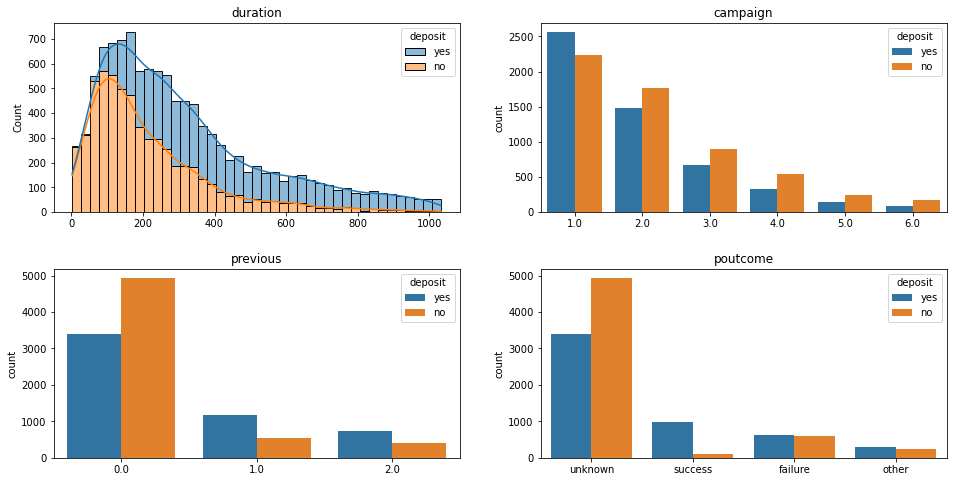

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.countplot(data=data2, x="day", hue=data2.deposit, ax=ax[0])
ax[0].set_title("day")
ax[0].set_xlabel("")
ax[0].set_xticklabels(range(1,32))
sns.countplot(data=data2, x="month", ax=ax[1], order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                                      'sep', 'oct', "nov", "dec"], hue=data2.deposit)
ax[1].set_title("month")
ax[1].set_xlabel("")
fig.suptitle('Variables de campaña vs deposit', fontsize=16)
plt.show()


fig, ax = plt.subplots(2, 2, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.histplot(data=data2, x="duration", kde=True, hue=data2.deposit, ax=ax[0,0], multiple="stack")
ax[0,0].set_title("duration")
ax[0,0].set_xlabel("")
sns.countplot(data=data2, x="campaign", hue=data2.deposit, ax=ax[0,1])
ax[0,1].set_title("campaign")
ax[0,1].set_xlabel("")
sns.countplot(data=data2, x="previous", hue=data2.deposit, ax=ax[1,0])
ax[1,0].set_title("previous")
ax[1,0].set_xlabel("")
sns.countplot(data=data2, x="poutcome", hue=data2.deposit, ax=ax[1,1])
ax[1,1].set_title("poutcome")
ax[1,1].set_xlabel("")
plt.show()

* En primer lugar podemos observar que los días en donde se tuvo mayor éxito con respecto a la solicitud de un depósito a plazo fijo son los días 1 y 10 de cada mes, el éxito que se tiene en el día 1 puede deberse a que este es un día después del que los clientes reciben su pago mensual por laborar, entonces, al tener una cantidad considerable de dinero en sus manos, es más fácil persuadirlos para que lo inviertan en el banco, también podemos ver que este día es uno de los que menos contacto se tiene con el cliente, por lo tanto se podría recomendar para la próxima campaña aprovechar este día para persuadir a más personas. Con respecto a los días en los que no se tuvo éxito, podemos observar que estos son el 19, 20, 28 y 29 de cada mes.

* Por otra parte, observamos que los meses en los que se tuvo mayor éxito fueron marzo, septiembre, octubre y en menor medida diciembre, mientras que el mes en el que se tuvo un mayor fracaso fue mayo.

* Con respecto a la variable "duration", se puede observar que en un principio los pocos segundos de comunicación con el cliente tienen una proporción similar de clientes que solicitaron y no solicitaron el depósito, y que a medida que el tiempo de contacto se vaya prolongando, hay mejores probabilidades de que este termine aceptando realizar este tipo de depósito. Esta es una conducta normal, ya que cuando una persona está interesada en adquirir algún producto o servicio, surgen diversas preguntas acerca de ello, lo cual, naturalmente prolonga el tiempo de comunicación con el individuo o entidad que brinda dicho servicio.

* En la variable "campaign" se puede apreciar que no existe un patrón que indique con certeza que un determinado número de contactos favorece a la solicitud de un depósito a plazo fijo, aunque observamos que existen más clientes que aceptaron realizar el depósito cuando se realizó solo 1 contacto con ellos, la diferencia entre los que aceptaron o no, no es muy grande para considerarlo relevante.

* Con "previous" no podemos decir lo mismo, ya que se ve que los clientes que no han sido contactados en una campaña anterior para ofrecerles este tipo de depósito son menos propensos a aceptar dicho depósito en la campaña actual, mientras que aquellos que si han sido contactados anteriormente, tienen una leve inclinación a solicitar este tipo de servicio.

* Por último, respecto a la variable "poutcome", podemos observar que aquellos clientes de los que no se sabe si aceptaron o no solicitar un depósito a plazo fijo en la campaña anterior tienen una tendencia a no aceptar este tipo de depósito en la campaña actual, cabe mencionar que si su decisión fue etiquetada como desconocida, podría deberse a que son nuevos clientes, ya que esta variable guarda relación con "previous", en donde se puede observar que la cantidad de clientes a los que no se les han contactado en la campaña anterior (0) es la misma que los que los que están etiquetados como "unknown". Por otro lado, observamos que aquellos clientes a los cuales se les pudo persuadir para solicitar este tipo de depósito en la campaña anterior, con mucha probabilidad volverán a aceptar solicitar este servicio en la campaña actual.

Resumiendo toda la información obtenida tenemos que: Los días que registraron mayor éxito en la solicitud de un depósito a plazo fijo fueron los 1 y 10 de cada mes, mientras que los que menos éxito tuvieron fueron los días 19, 20, 28 y 29. Asimismo los meses de mayor éxito fueron Marzo, Septiembre, Octubre y Diciembre, y el de menor éxito Mayo. También se observó que si se tiene una comunicación corta con el cliente, la posibilidad que este acepte solicitar este tipo de depósito es casi la misma que la de no solicitarlo, y que mientras mayor sea el tiempo de contacto, mayor será la posibilidad de tener éxito en su persuasión. El número de contactos que se tiene con el cliente parece no afectar en su decisión, sin embargo, variables referentes a la campaña anterior como "previous" y "poutcome" parecen si afectar en esta decisión, donde se pudo identificar que aquellos clientes a los cuales no se les contactó en la campaña anterior y cuyo resultado de si aceptaron solicitar el depósito a plazo fijo o no es desconocido, tienen una tendencia a no solicitar este tipo de depósito en la campaña actual, mientras que aquellos de los que se sabe que si aceptaron solicitar este depósito en la campaña anterior, con mucha probabilidad volverán a solicitarlo en la campaña actual.

Respondiendo a las hipótesis tenemos que:

* H10: Los días en los que se observó que es más probable convencer a los clientes de solicitar un depósito a plazo fijo fueron el 1 y 10 de cada mes.
* H11: Los meses en los que se observó que es más probable convencer a los clientes de solicitar un depósito a plazo fijo fueron marzo, septiembre, octubre y diciembre.
* H12: A mayor duración en el tiempo de contacto con el cliente mayores posibilidades hay de que este termine aceptando solicitar un depósito a plazo fijo.
* H13: El número de contactos que se tiene con el cliente parece no afectar en su decisión de solicitar o no un depósito a plazo fijo.
* H14: El número de contactos que se tuvo con el cliente en la campaña anterior afecta en la posibilidad de solicitar un depósito a plazo fijo.
* H15: Aquellos clientes que solicitaron un depósito a plazo fijo en la campaña anterior con mucha probabilidad volverán a solicitar este tipo de depósito en la campaña actual.

---

A lo largo del proceso de análisis para responder las hipótesis que inicialmente habíamos planteado, nos hemos encontrado con algunos comportamientos y patrones particulares de los cuales se puede extraer información relevante para el análisis. Es por ello que en esta parte se compararan entre sí algunas de las variables más relevantes con respecto a la decisión de solicitar un depósito a plazo fijo con el fin de obtener insights que nos ayuden a entender un poco más el comportamiento de los clientes.

#### "job" vs "housing"

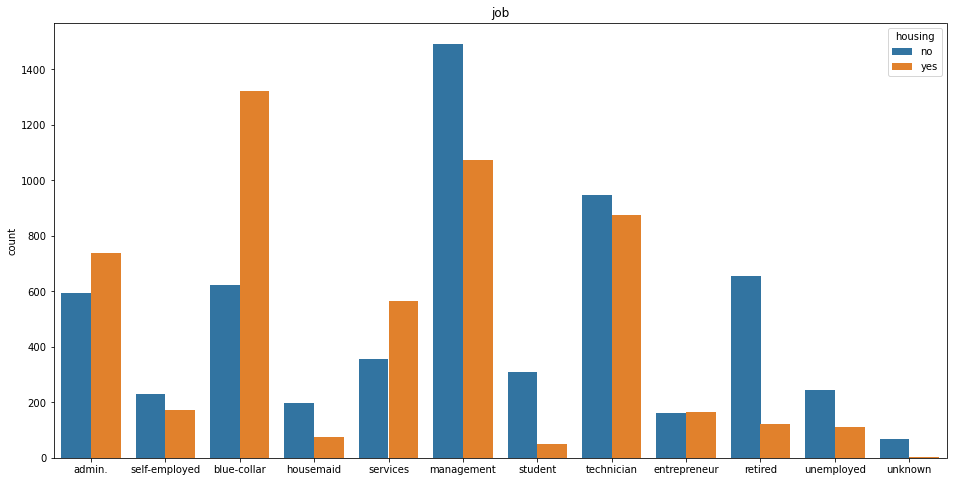

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.countplot(data=data2, x="job", hue=data2.housing)
ax.set_title("job")
ax.set_xlabel("")
plt.show()

Del grafico podemos observar que los clientes que trabajan de obrero son los que en su gran mayoría solicitan un préstamo de vivienda, es por ello que las personas con este tipo de trabajo son menos propensas a solicitar un depósito a plazo fijo, ya que como vimos en análisis anteriores, el dinero que piden prestado al banco va destinado a otros fines que no son los buscados en este análisis. Por otra parte, podemos observar que las personas que son estudiantes o retirados son menos propensas a solicitar un préstamo de vivienda, por lo tanto, uniendo los hilos con el análisis respecto a la variable "housing", es de esperar que estas personas tengan más probabilidades de solicitar un depósito a plazo fijo puesto que no tienen deudas con el banco, y probablemente su cultura financiera o experiencia les hace más atractivo el hecho de invertir que de gastar.

#### "previous" vs "poutcome"

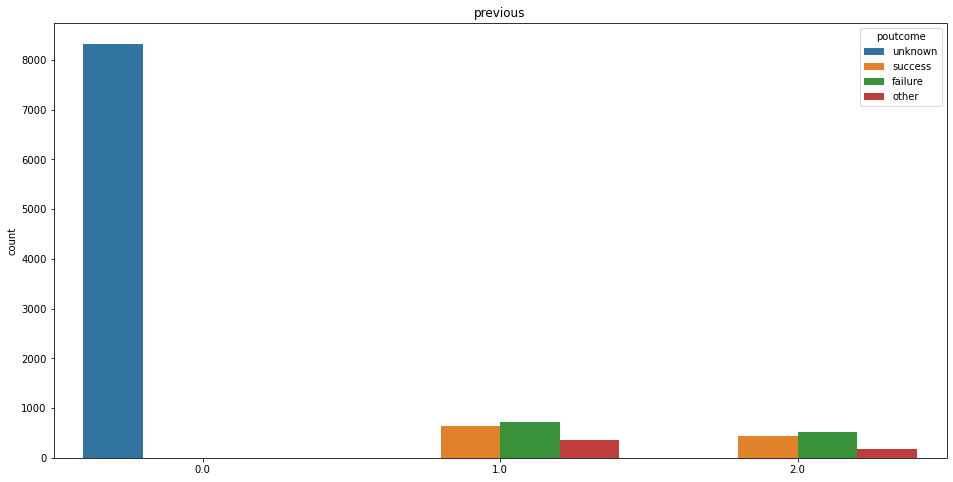

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.countplot(data=data2, x="previous", hue=data2.poutcome)
ax.set_title("previous")
ax.set_xlabel("")
plt.show()

Del siguiente grafico obtenemos un patrón muy obvio en donde los clientes que no han sido contactados en la campaña anterior, están etiquetados como resultado desconocido en si solicitaron o no un depósito a plazo fijo en la campaña anterior. Por otra parte, podemos observar que efectivamente el número de contactos que se tiene con el cliente no afecta en su decisión de solicitar o no este tipo de depósito, ya que como se puede apreciar, las personas que solicitaron y no solicitaron el depósito se distribuyen de forma muy equitativa.

#### "job" vs "duration"

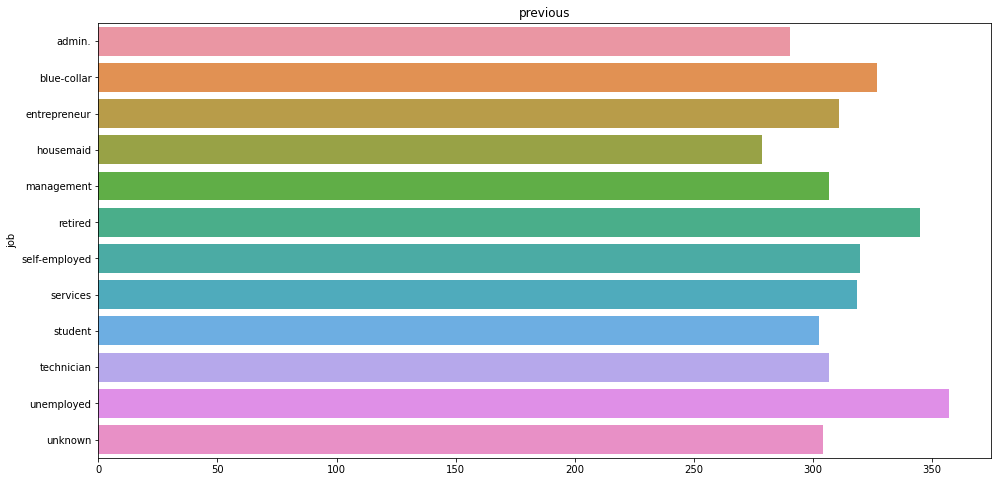

In [39]:
duration_mean = data2.groupby(["job"], as_index=False)["duration"].mean()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
sns.barplot(data=duration_mean, x="duration", y="job")
ax.set_title("previous")
ax.set_xlabel("")
plt.show()

Por último, podemos observar que la media de tiempo de contacto que se tiene con cada uno de los clientes pertenecientes a los distintos tipos de trabajo se distribuye de forma muy equitativa, donde la diferencia máxima que se puede apreciar es de 1 minuto. Aunque podemos ver que el tiempo de contacto que se tienen con los clientes que se encuentran desempleados es ligeramente mayor al resto, esto podría deberse a que la situación de estas personas les obliga a tener una fuente de ingresos para poder subsistir, por lo tanto, el tiempo de contacto con ellos se ve más prolongado al tener más interés en consultar como es el funcionamiento de este tipo de depósito y sus beneficios.

Para terminar con esta sección, graficaremos una matriz de correlación para identificar el comportamiento conjunto de nuestras variables sobre otras. Como estamos tratando tanto con variables categóricas como numéricas, será necesario aplicar la correlación de Pearson para las características numéricas, y la V de Cramer para las categóricas.

### Correlación de Pearson

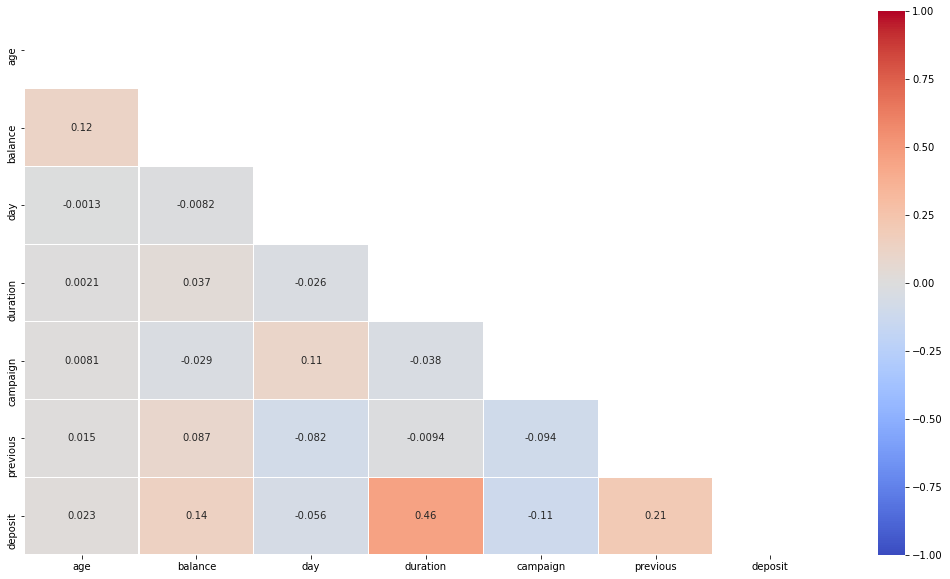

In [40]:
data_corr = data2.copy()

data_corr["deposit"] = LabelEncoder().fit_transform(data_corr["deposit"])

plt.figure(figsize=(18, 10))
corr = data_corr[["age","balance","day","duration","campaign","previous","deposit"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

De la matriz observamos que las variables numéricas con mayor correlación hacia nuestra variable dependiente son "duration" y "previous". La influencia de estas variables ya lo habíamos analizado y gracias a esta matriz nuestras suposiciones están mejor respaldadas. Respecto a "duration", habíamos llegado a la conclusión que mientras mayor era el número de segundos en el que se mantenía contacto con el cliente, mayores eran las posibilidades de que este terminara aceptando solicitar el depósito. Y con respecto a "previous", identificamos que los clientes que no habían sido contactados en una campaña anterior, tenían más probabilidad de no solicitar el depósito en la campaña actual.

### V de Cramer

In [41]:
data_corr = data2.copy()

data_corr = data_corr.apply(lambda x: x.astype("category") if x.dtype == "O" else x)
cramersv = am.CramersV(data_corr) 
result = cramersv.fit()
result

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
job,1.000000,0.237119,0.463411,0.052665,0.310399,0.138390,0.183559,0.106512,0.088024,0.184042
marital,0.237119,1.000000,0.125151,0.019688,0.043951,0.066169,0.060822,0.070477,0.037833,0.099083
education,0.463411,0.125151,1.000000,0.016948,0.137680,0.093441,0.131042,0.103186,0.049187,0.104876
default,0.052665,0.019688,0.016948,1.000000,0.011076,0.076434,0.045782,0.066789,0.055013,0.040680
housing,0.310399,0.043951,0.137680,0.011076,1.000000,0.076761,0.260481,0.476735,0.154566,0.203888
loan,0.138390,0.066169,0.093441,0.076434,0.076761,1.000000,0.022654,0.182041,0.084673,0.110580
contact,0.183559,0.060822,0.131042,0.045782,0.260481,0.022654,1.000000,0.460565,0.207636,0.256904
month,0.106512,0.070477,0.103186,0.066789,0.476735,0.182041,0.460565,1.000000,0.187564,0.306236
poutcome,0.088024,0.037833,0.049187,0.055013,0.154566,0.084673,0.207636,0.187564,1.000000,0.300008
deposit,0.184042,0.099083,0.104876,0.040680,0.203888,0.110580,0.256904,0.306236,0.300008,1.000000


Con respecto a la asociación entre nuestras variables categóricas y nuestra variable dependiente podemos observar que aquellas cuyo valor de asociación es mayor que el resto son "housing", "contact", "month" y "poutcome", las cuales en análisis anteriores habíamos observado que presentaban ciertos patrones que indicaban la inclinación del cliente hacia solicitar o no solicitar un depósito a plazo fijo. Donde los clientes que solicitaron un préstamo de vivienda eran menos propensos a solicitar este tipo de depósito, al iguales que los clientes de los que no se conocía el medio de comunicación por el cual se les contactaba. Con respecto a los meses, observamos que había algunos en los que se tenían resultados muchos más positivos y otros en los que no había mucho éxito. Por último, también pudimos identificar que aquellos clientes que habían solicitado realizar este tipo de depósito en la campaña anterior con mucha probabilidad volverían a solicitarlo en la campaña actual, mientras que aquellos que eran nuevos en el banco y no se tenía un registro acerca de su decisión, tenían una tendencia a no solicitar este servicio.

Gracias al valor de la asociación de Cramer también podemos obtener algunos otros insights interesantes como:

#### "month" vs "housing"

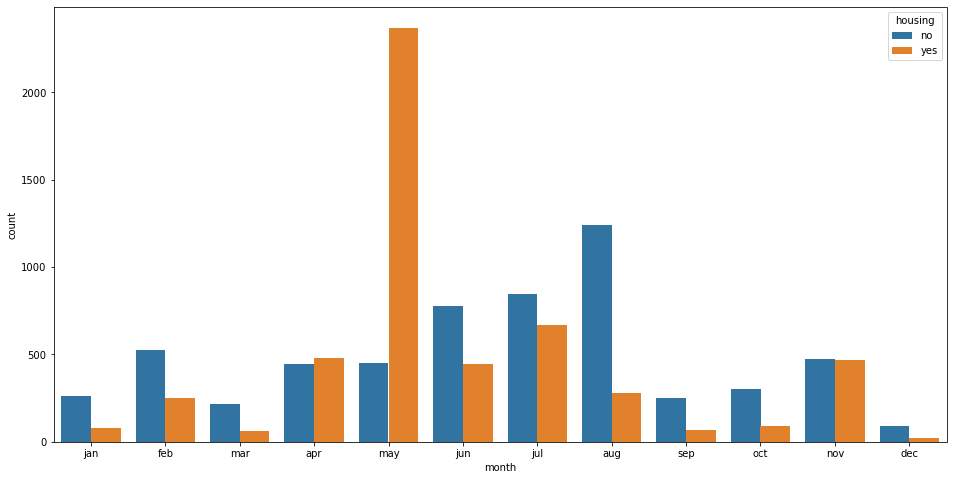

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data=data2, x="month", order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', "nov", "dec"],
              hue=data2.housing)
plt.show()

En donde podemos observar que existe un número significativo de clientes que han sido contactados por última vez en mayo y que han solicitado un préstamo de vivienda. Esto podría indicar que los clientes tienen una tendencia a solicitar este préstamo un mes antes de Mayo, ya que se puede observar cómo en Abril el número de personas con esta solicitud van en aumento, y como pasado el mes de Mayo este número decrece, volviendo a un estado estándar en el que el número de personas que no solicitaron este tipo de préstamos son mayores o iguales a las que si lo solicitaron.

#### "job" vs "education"

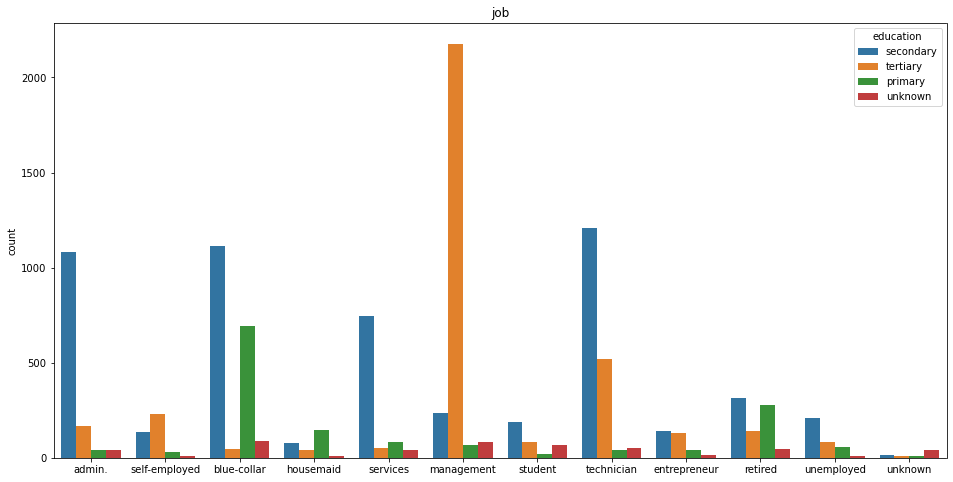

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(data=data2, x="job", hue=data2.education)
ax.set_title("job")
ax.set_xlabel("")
plt.show()

Por último, podemos observar un patrón completamente normal en donde la mayoría de personas que tienen cargos relacionados con la gerencia, tienen estudios terciarios (universitarios o de instituto). Y que los demás puestos de trabajo están conformados por personas cuyo grado de educación mayormente es secundario, excepto en el caso de los obreros, retirados y amas de casa, donde la distribución entre las personas con educación secundaria y primaria es casi equitativa.

---

## 6. Tranformación de datos

Empezaremos por eliminar la variable "duration" de la cual anteriormente habíamos hablado, ya que aporta información de la cual no se dispone en la realidad al momento de predecir si un cliente solicitara o no un depósito a plazo fijo, ya que la duración de la llamada con el cliente se conoce después de saber la decisión de este, mas no antes.

In [44]:
data = data.drop(["duration"], axis=1)
data2 = data2.drop(["duration"], axis=1)

### Codificación de variables

Como uno de los objetivos de este proyecto es implementar CatBoost para la predicción de clientes que solicitaran o no un depósito a plazo fijo en el futuro, no será necesario codificar de forma manual nuestras variables categóricas, ya que CatBoost internamente realiza este proceso por nosotros, implementando una codificación basada en Target Encoder con algunas modificaciones que el algoritmo cree pertinente. Solo sería necesario aplicar una codificación de etiqueta a nuestra variable dependiente solo si esta es dicotómica. Sin embargo, para demostrar que efectividad tiene el delegarle la codificación a CatBoost y hacerlo de forma manual en la precisión de nuestro modelo, construiremos dos modelos utilizando ambas técnicas y posteriormente evaluaremos su rendimiento.

#### Con codificación manual

Puesto que el algoritmo que vamos a utilizar está basado en árboles de decisión, para evitar el aumento exponencial de variables independientes al implementar una codificación One Hot Econding y todos los problemas que esto conlleva, podemos utilizar Label Encoder como alternativa, ya que los árboles de decisión no se ven perjudicados al tener variables ordinales que originalmente son nominales.

* Codificación de variables en el conjunto con outliers

In [45]:
data_cod = data.copy()

cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome", "deposit"]

for col in cols:
    data_cod[col] = LabelEncoder().fit_transform(data_cod[col])

* Codificación de variables en el conjunto sin outliers

In [46]:
data2_cod = data2.copy()

for col in cols:
    data2_cod[col] = LabelEncoder().fit_transform(data2_cod[col])

#### Sin codificación manual

* Codificación de etiqueta a la variable dependiente del conjunto con outliers 

In [47]:
data["deposit"] = LabelEncoder().fit_transform(data["deposit"])

* Codificación de etiqueta a la variable dependiente del conjunto sin outliers 

In [48]:
data2["deposit"] = LabelEncoder().fit_transform(data2["deposit"])

### Creación de conjuntos de entrenamiento y validación

#### Para datos con outliers y sin codificación manual

In [49]:
X = data.iloc[: , :-1].values
y = data.iloc[: , -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21, stratify=y)

#### Para datos con outliers y con codificación manual

In [50]:
X_cod = data_cod.iloc[: , :-1].values
y_cod = data_cod.iloc[: , -1].values

X_train_cod, X_test_cod, y_train_cod, y_test_cod = train_test_split(X_cod, y_cod, test_size=0.30, random_state=21, stratify=y)

#### Para datos sin outliers y sin codificación manual

In [51]:
X2 = data2.iloc[: , :-1].values
y2 = data2.iloc[: , -1].values

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.30, random_state=21, stratify=y)

#### Para datos sin outliers y con codificación manual

In [52]:
X2_cod = data2_cod.iloc[: , :-1].values
y2_cod = data2_cod.iloc[: , -1].values

X2_train_cod, X2_test_cod, y2_train_cod, y2_test_cod = train_test_split(X2_cod, y2_cod, test_size=0.30, random_state=21, stratify=y)

### Rebalanceo de datos

Empezaremos comprobando el número de muestras para cada una de las clases que tiene nuestra variable dependiente para identificar si tenemos un conjunto de datos desbalanceado.

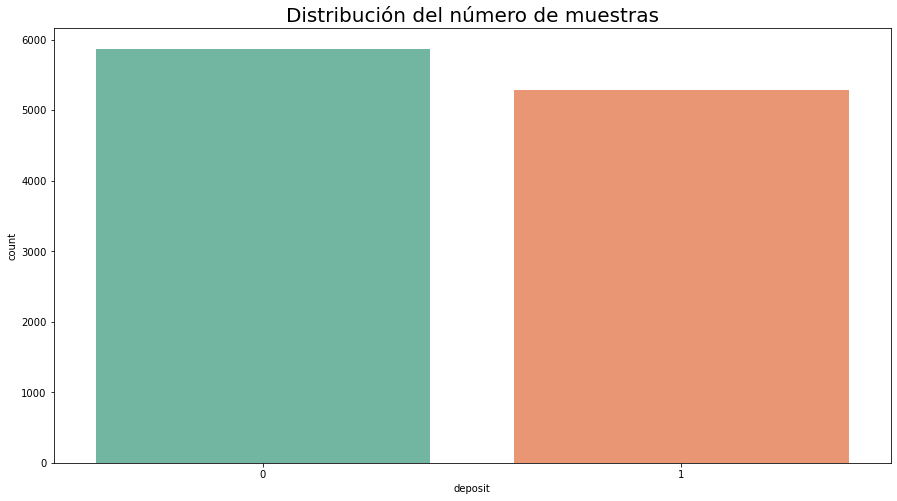

In [53]:
plt.figure(figsize=(15, 8))
sns.countplot(data=data2, x="deposit", palette=["#66c2a5", "#fc8d62"])
plt.title("Distribución del número de muestras", fontsize=20)
plt.show()

In [54]:
counter_total = Counter(data["deposit"])
print(counter_total)

Counter({0: 5873, 1: 5289})


Observamos que no tenemos una desproporción muy grave con respecto al número de muestras en cada clase, por lo tanto, podemos obviar el uso de técnicas de sobre muestreo y submuestreo para el rebalanceo de muestras. Cabe mencionar que CatBoost también posee un hiperparámetro encargado de solucionar este problema, añadiendo pesos a las muestras de la clase minoritaria para que su impacto en el modelo sea casi el mismo que el de la clase mayoritaria, por lo tanto, podríamos hacer uso de esta función para mejorar un poco más el rendimiento predictivo de nuestro modelo.

---

## 7. Construcción y evaluación del modelo predictivo

Como ya se mencionó en la introducción de este proyecto, para la construcción de un modelo predictivo utilizaremos CatBoost.

El motivo principal por el que elegimos este algoritmo basado en el aumento del gradiente es porque ofrece soporte para el trabajo de clasificación y regresión con variables categóricas sin la necesidad de pre procesarlas, además que en la mayoría de ocasiones se puede obtener resultados considerablemente buenos sin realizar demasiados ajustes en los hiperparametros. Y por último, porque es relativamente rápido entrenarlo, incluso cuando se tiene una cantidad considerable de datos. Estas cualidades encajan bien con nuestro conjunto de datos, puesto que tenemos alrededor de 11000 observaciones las cuales tienen características pertenecientes tanto a variables categóricas como numéricas.

### Elección de hiperparámetros

Como anteriormente habíamos dicho, CatBoost puede obtener resultados buenos con la configuración de hiperparametros predeterminada, sin embargo, el objetivo de este proyecto es obtener el mejor modelo posible que pueda predecir de forma correcta la solicitud de depósito a plazo fijo de los clientes, es por ello que haciendo uso de la librería Optuna, mediante la optimización bayesiana, intentaremos encontrar la combinación de hiperparametros que mejor se ajuste a nuestros datos.

Dado que a lo largo de este proyecto hemos realizado distintas transformaciones a nuestros datos, y hemos guardado una copia del conjunto de datos antes de realizar dicha transformación, aplicaremos la función de búsqueda de hiperparametros a cada uno de estos conjuntos, con el fin de comparar hasta que paso de la transformación es necesaria para obtener el modelo con el mejor rendimiento posible, o si para este caso, no es necesario aplicar transformación alguna. Es por ello que dividiremos esta sección en cuatro partes, basado en los cuatro conjuntos de datos obtenidos:

* Hiperparámetros para datos con outliers y sin codificación manual
* Hiperparámetros para datos con outliers y con codificación manual
* Hiperparámetros para datos sin outliers y sin codificación manual
* Hiperparámetros para datos sin outliers y con codificación manual

* ### Hiperparámetros para datos con outliers y sin codificación manual

In [ ]:
def objective(trial):   

    params = {"iterations": trial.suggest_int("iterations",300,1200,100),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
              "depth": trial.suggest_int("depth", 4, 12, 1),
              "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 10),
              "random_strength":trial.suggest_int("random_strength", 0, 40, 1),
              "bagging_temperature": trial.suggest_int("bagging_temperature", 0, 2, 1),
              'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 10),
              "auto_class_weights": "Balanced",
              "loss_function": "Logloss",
              "eval_metric": "AUC",
              "task_type": "GPU",
              "od_type" : "Iter",  # Parametros relacionados con early stop
              "od_wait" : 30,
              "use_best_model": True,
              "random_seed": 42}
    
    # Identificación de variables categoricas
    categorical_features_indices = np.where(data.dtypes == np.object)[0]
    
    train_pool = Pool(X_train, y_train, cat_features = categorical_features_indices)
    test_pool = Pool(X_test, y_test, cat_features = categorical_features_indices)
    
    # Inicialización y entrenamiento del modelo
    model = CatBoostClassifier(**params) 
    model.fit(train_pool, eval_set=test_pool, verbose=True)
    
    # Evaluación y obtención de métricas
    preds = model.predict(X_test)
    metric = accuracy_score(y_test, preds)
    
    return metric

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

In [ ]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))
best_1 = study.trials_dataframe()

Se ejecutó la función tres veces de forma independiente, y posterior a ello, se registró la mejor combinación de hiperparámetros que arrojo cada ejecución, siendo estas las siguientes:

* 73.96% | iterarions=600, learning_rate=0.166129, depth=7, l2_leaf_reg=0.963535, random_strength=11, bagging_temperature=1, max_ctr_complexity=0
* 74.08% | iterarions=1200, learning_rate=0.246729, depth=9, l2_leaf_reg=7.2024, random_strength=33, bagging_temperature=1, max_ctr_complexity=2
* 73.72% | iterarions=500, learning_rate=0.208787, depth=10, l2_leaf_reg=1.25048, random_strength=15, bagging_temperature=1, max_ctr_complexity=2

Procederemos a entrenar modelos CatBoost en base a estas tres combinaciones de hiperparámetros obtenidas para determinar cuál de ellas presenta mejores resultados al clasificar nuestros datos.

#### Identificación de variables categóricas

In [55]:
categorical_features_indices1 = np.where(data.dtypes == np.object)[0]
train_pool1 = Pool(X_train, y_train, cat_features = categorical_features_indices1)
test_pool1 = Pool(X_test, y_test, cat_features = categorical_features_indices1)

#### Para la primera combinación

In [56]:
cb_1a = CatBoostClassifier(iterations=600, learning_rate=0.166129, depth=7, l2_leaf_reg=0.963535, random_strength=11,
                            bagging_temperature=1, max_ctr_complexity=0, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_1a.fit(train_pool1, eval_set = test_pool1, logging_level="Silent")
y_pred_1a = cb_1a.predict(X_test)

#### Para la segunda combinación

In [57]:
cb_1b = CatBoostClassifier(iterations=1200, learning_rate=0.246729, depth=9, l2_leaf_reg=7.2024, random_strength=33,
                            bagging_temperature=1, max_ctr_complexity=2, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_1b.fit(train_pool1, eval_set = test_pool1, logging_level="Silent")
y_pred_1b = cb_1b.predict(X_test)

#### Para la tercera combinación

In [58]:
cb_1c = CatBoostClassifier(iterations=500, learning_rate=0.208787, depth=10, l2_leaf_reg=1.25048, random_strength=15,
                            bagging_temperature=1, max_ctr_complexity=2, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_1c.fit(train_pool1, eval_set = test_pool1, logging_level="Silent")
y_pred_1c = cb_1c.predict(X_test)

#### Comparación de rendimiento entre combinaciones

#### Para la primera combinación

In [59]:
f1_1a = f1_score(y_test, y_pred_1a)
acc_1a = accuracy_score(y_test, y_pred_1a)
auc_1a = roc_auc_score(y_test, y_pred_1a)
report_1a = classification_report(y_test,y_pred_1a)

#### Para la segunda combinación

In [60]:
f1_1b = f1_score(y_test, y_pred_1b)
acc_1b = accuracy_score(y_test, y_pred_1b)
auc_1b = roc_auc_score(y_test, y_pred_1b)
report_1b = classification_report(y_test,y_pred_1b)

#### Para la tercera combinación

In [61]:
f1_1c = f1_score(y_test, y_pred_1c)
acc_1c = accuracy_score(y_test, y_pred_1c)
auc_1c = roc_auc_score(y_test, y_pred_1c)
report_1c = classification_report(y_test,y_pred_1c)

A continuación, visualizaremos el puntaje de la métrica F1 y la precisión para cada combinación, a la vez que también observaremos un reporte de las principales métricas para evaluar la capacidad de clasificación de nuestros modelos.

In [62]:
print("F1 primera comb.: %.2f%%" % (f1_1a * 100.0))
print("Accuracy primera comb.: %.2f%%" % (acc_1a * 100.0))
print("-------------------------------")
print("F1 segunda comb.: %.2f%%" % (f1_1b * 100.0))
print("Accuracy segunda comb.: %.2f%%" % (acc_1b * 100.0))
print("-------------------------------")
print("F1 tercera comb.: %.2f%%" % (f1_1c * 100.0))
print("Accuracy tercera comb.: %.2f%%" % (acc_1c * 100.0))

F1 primera comb.: 69.65%
Accuracy primera comb.: 73.69%
-------------------------------
F1 segunda comb.: 69.63%
Accuracy segunda comb.: 73.90%
-------------------------------
F1 tercera comb.: 69.47%
Accuracy tercera comb.: 73.37%


In [63]:
print(report_1a)
print("-------------------------------------------------")
print(report_1b)
print("-------------------------------------------------")
print(report_1c)

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1762
           1       0.77      0.64      0.70      1587

    accuracy                           0.74      3349
   macro avg       0.74      0.73      0.73      3349
weighted avg       0.74      0.74      0.73      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.84      0.77      1762
           1       0.78      0.63      0.70      1587

    accuracy                           0.74      3349
   macro avg       0.75      0.73      0.73      3349
weighted avg       0.74      0.74      0.74      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.82      0.76      1762
           1       0.76      0.64      0.69      1587

    accuracy                           0.73      3349
   macro avg       0.74     

En principio, observamos que tanto la primera como la segunda combinación presentan valores de métrica superiores en comparación con la tercera combinación, aunque la diferencia entre ellos es mínima.

Procederemos a graficar la matriz de confusión y la curva ROC-AUC.

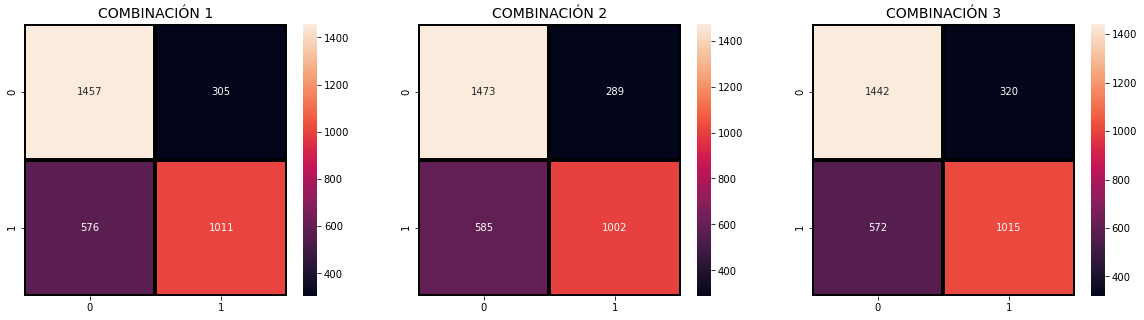

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_1a), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[0])
ax[0].set_title("COMBINACIÓN 1",fontsize=14)

sns.heatmap(confusion_matrix(y_test, y_pred_1b), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[1])
ax[1].set_title("COMBINACIÓN 2",fontsize=14)

sns.heatmap(confusion_matrix(y_test, y_pred_1c), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[2])
ax[2].set_title("COMBINACIÓN 3",fontsize=14)

plt.show()

Con respecto a las matrices de confusión, observamos que la segunda combinación presenta un ratio mejor equilibrado al momento de predecir correctamente si un cliente solicita un depósito a plazo fijo o no, a la vez que también observamos que la tercera combinación presenta resultados ineficientes al realizar esta clasificación, ya que predice correctamente más muestras positivas (1) en comparación de las demás combinaciones, pero a coste de una cantidad considerable en la correcta predicción de muestras negativas (0). Es por ello que tomaremos en cuenta a la segunda combinación como la que mejores resultados arrojó en este apartado de evaluación.

In [65]:
y_pred_prob1a = cb_1a.predict_proba(X_test)[:,1]
fpr_1a, tpr_1a, thresholds_1a = roc_curve(y_test, y_pred_prob1a)
y_pred_prob1b = cb_1b.predict_proba(X_test)[:,1]
fpr_1b, tpr_1b, thresholds_1b = roc_curve(y_test, y_pred_prob1b)
y_pred_prob1c = cb_1c.predict_proba(X_test)[:,1]
fpr_1c, tpr_1c, thresholds_1c = roc_curve(y_test, y_pred_prob1c)

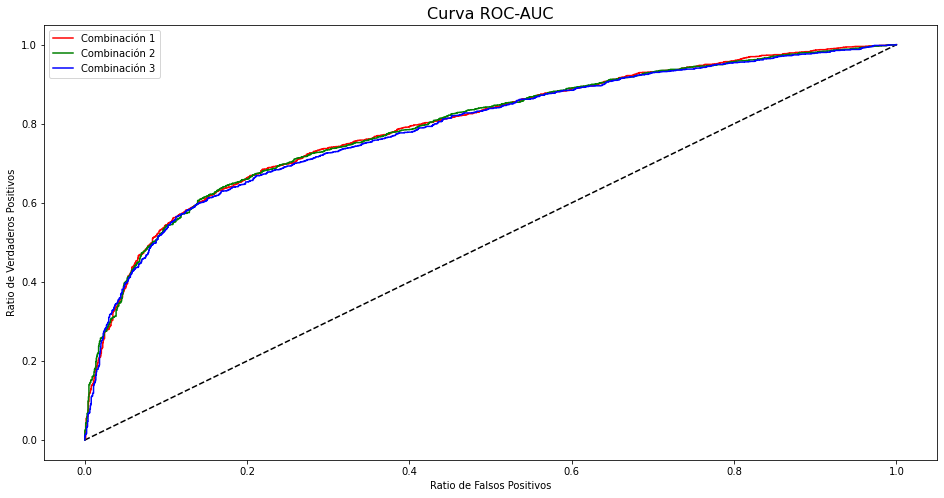

In [66]:
plt.figure(figsize=(16, 8))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_1a, tpr_1a, label='Combinación 1',color = "r")
plt.plot(fpr_1b, tpr_1b, label='Combinación 2',color = "g")
plt.plot(fpr_1c, tpr_1c, label='Combinación 3',color = "b")
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('Curva ROC-AUC',fontsize=16)
plt.legend()
plt.show()

Del grafico de la curva ROC-AUC no podemos diferenciar claramente si la combinación 1 o 2 es la que mejor tasa de verdaderos positivos (VP) y falsos positivos (FP) tiene, sin embargo, podemos observar que la curva de la tercera combinación tiende a ser menor comparado con las demás combinaciones, por lo que combinado con los resultados de las métricas anteriores, podemos ir descartando esta combinación.

In [67]:
print("AUC primera comb.: %.2f%%" % (auc_1a * 100.0))
print("AUC segunda comb.: %.2f%%" % (auc_1b * 100.0))
print("AUC tercera comb.: %.2f%%" % (auc_1c * 100.0))

AUC primera comb.: 73.20%
AUC segunda comb.: 73.37%
AUC tercera comb.: 72.90%


Por último, podemos ver que el valor de la métrica AUC nos da claridad al momento de decidir qué combinación presenta una mejor tasa de VP y FP, ya que como habíamos deducido anteriormente, la tercera combinación es la que peores resultados arroja, y que tanto la primera como la segunda combinación presentan resultados similares, sin embargo, la segunda combinación presenta una ligera superioridad comparado con las demás combinaciones. Entonces, uniendo los resultados de las métricas anteriormente vistas, podemos concluir que el modelo construido con la segunda combinación es el que mejor clasifica estos datos, por lo tanto, utilizaremos este modelo como referente del conjunto de "Hiperparámetros para datos con outliers y sin codificación manual".

* ### Hiperparámetros para datos con outliers y con codificación manual

In [ ]:
def objective(trial):   

    params = {"iterations": trial.suggest_int("iterations",300,1200,100),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
              "depth": trial.suggest_int("depth", 4, 12, 1),
              "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 10),
              "random_strength":trial.suggest_int("random_strength", 0, 40, 1),
              "bagging_temperature": trial.suggest_int("bagging_temperature", 0, 2, 1),
              'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 10),
              "auto_class_weights": "Balanced",
              "loss_function": "Logloss",
              "eval_metric": "AUC",
              "task_type": "GPU",
              "od_type" : "Iter",
              "od_wait" : 30,
              "use_best_model": True,
              "random_seed": 42}
    
    train_pool = Pool(X_train_cod, y_train_cod)
    test_pool = Pool(X_test_cod, y_test_cod)
    
    # Inicialización y entrenamiento del modelo
    model = CatBoostClassifier(**params) 
    model.fit(train_pool, eval_set=test_pool, verbose=True)
    
    # Evaluación y obtención de métricas
    preds = model.predict(X_test_cod)
    metric = accuracy_score(y_test_cod, preds)
    
    return metric

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

In [ ]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))
best_2 = study.trials_dataframe()

Se ejecutó la función tres veces de forma independiente, y posterior a ello, se registró la mejor combinación de parámetros que arrojó cada ejecución, siendo estas las siguientes:

* 74.29% | iterarions=900, learning_rate=0.198706, depth=9, l2_leaf_reg=4.72514, random_strength=40, bagging_temperature=0, max_ctr_complexity=3
* 74.23% | iterarions=1000, learning_rate=0.0686307, depth=7, l2_leaf_reg=6.87847, random_strength=2, bagging_temperature=1, max_ctr_complexity=1
* 74.17% | iterarions=500, learning_rate=0.103597, depth=11, l2_leaf_reg=7.95198, random_strength=8, bagging_temperature=0, max_ctr_complexity=4

Procederemos a entrenar modelos CatBoost en base a estas tres combinaciones de hiperparámetros obtenidas para determinar cuál de ellas presenta mejores resultados al clasificar nuestros datos.

In [68]:
train_pool2 = Pool(X_train_cod, y_train_cod)
test_pool2 = Pool(X_test_cod, y_test_cod)

#### Para la primera combinación

In [69]:
cb_2a = CatBoostClassifier(iterations=900, learning_rate=0.198706, depth=9, l2_leaf_reg=4.72514, random_strength=40,
                            bagging_temperature=0, max_ctr_complexity=3, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_2a.fit(train_pool2, eval_set = test_pool2, logging_level="Silent")
y_pred_2a = cb_2a.predict(X_test_cod)

#### Para la segunda combinación

In [70]:
cb_2b = CatBoostClassifier(iterations=1000, learning_rate=0.0686307, depth=7, l2_leaf_reg=6.87847, random_strength=2,
                            bagging_temperature=1,  max_ctr_complexity=1, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_2b.fit(train_pool2, eval_set = test_pool2, logging_level="Silent")
y_pred_2b = cb_2b.predict(X_test_cod)

#### Para la tercera combinación

In [71]:
cb_2c = CatBoostClassifier(iterations=500, learning_rate=0.103597, depth=11, l2_leaf_reg=7.95198, random_strength=8,
                            bagging_temperature=0, max_ctr_complexity=4, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_2c.fit(train_pool2, eval_set = test_pool2, logging_level="Silent")
y_pred_2c = cb_2c.predict(X_test_cod)

#### Comparación de rendimiento entre combinaciones

#### Para la primera combinación

In [72]:
f1_2a = f1_score(y_test_cod, y_pred_2a)
acc_2a = accuracy_score(y_test_cod, y_pred_2a)
auc_2a = roc_auc_score(y_test_cod, y_pred_2a)
report_2a = classification_report(y_test_cod,y_pred_2a)

#### Para la segunda combinación

In [73]:
f1_2b = f1_score(y_test_cod, y_pred_2b)
acc_2b = accuracy_score(y_test_cod, y_pred_2b)
auc_2b = roc_auc_score(y_test_cod, y_pred_2b)
report_2b = classification_report(y_test_cod,y_pred_2b)

#### Para la tercera combinación

In [74]:
f1_2c = f1_score(y_test_cod, y_pred_2c)
acc_2c = accuracy_score(y_test_cod, y_pred_2c)
auc_2c = roc_auc_score(y_test_cod, y_pred_2c)
report_2c = classification_report(y_test_cod,y_pred_2c)

In [75]:
print("F1 primera comb.: %.2f%%" % (f1_2a * 100.0))
print("Accuracy primera comb.: %.2f%%" % (acc_2a * 100.0))
print("-------------------------------")
print("F1 segunda comb.: %.2f%%" % (f1_2b * 100.0))
print("Accuracy segunda comb.: %.2f%%" % (acc_2b * 100.0))
print("-------------------------------")
print("F1 tercera comb.: %.2f%%" % (f1_2c * 100.0))
print("Accuracy tercera comb.: %.2f%%" % (acc_2c * 100.0))

F1 primera comb.: 70.57%
Accuracy primera comb.: 73.72%
-------------------------------
F1 segunda comb.: 70.46%
Accuracy segunda comb.: 73.78%
-------------------------------
F1 tercera comb.: 70.72%
Accuracy tercera comb.: 73.99%


In [76]:
print(report_2a)
print("-------------------------------------------------")
print(report_2b)
print("-------------------------------------------------")
print(report_2c)

              precision    recall  f1-score   support

           0       0.73      0.80      0.76      1762
           1       0.75      0.66      0.71      1587

    accuracy                           0.74      3349
   macro avg       0.74      0.73      0.73      3349
weighted avg       0.74      0.74      0.74      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.81      0.76      1762
           1       0.76      0.66      0.70      1587

    accuracy                           0.74      3349
   macro avg       0.74      0.73      0.73      3349
weighted avg       0.74      0.74      0.74      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1762
           1       0.76      0.66      0.71      1587

    accuracy                           0.74      3349
   macro avg       0.74     

Se puede observar que, si bien todos los valores de métrica para todas las combinaciones que tenemos son muy similares, la tercera combinación es la que destaca por un pequeño margen porcentual de las demás. Mientras que tanto la primera como la segunda combinación parecen tener un rendimiento equivalente.

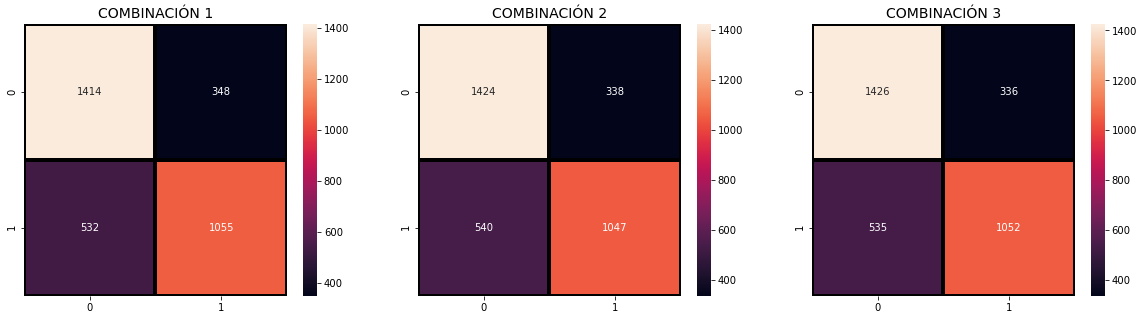

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(confusion_matrix(y_test_cod, y_pred_2a), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[0])
ax[0].set_title("COMBINACIÓN 1",fontsize=14)

sns.heatmap(confusion_matrix(y_test_cod, y_pred_2b), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[1])
ax[1].set_title("COMBINACIÓN 2",fontsize=14)

sns.heatmap(confusion_matrix(y_test_cod, y_pred_2c), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[2])
ax[2].set_title("COMBINACIÓN 3",fontsize=14)

plt.show()

De las matrices de confusión podemos reafirmar nuestra suposición al observar que la tercera combinación es la que presenta un mejor ratio de VP y FP, mientras que la segunda y la primera combinación presentan ratios que se complementan entre sí, ya que el punto fuerte de la primera combinación son los VP, mientras que su punto débil, los FP, es el punto fuerte de la segunda combinación.

In [78]:
y_pred_prob2a = cb_2a.predict_proba(X_test_cod)[:,1]
fpr_2a, tpr_2a, thresholds_2a = roc_curve(y_test_cod, y_pred_prob2a)
y_pred_prob2b = cb_2b.predict_proba(X_test_cod)[:,1]
fpr_2b, tpr_2b, thresholds_2b = roc_curve(y_test_cod, y_pred_prob2b)
y_pred_prob2c = cb_2c.predict_proba(X_test_cod)[:,1]
fpr_2c, tpr_2c, thresholds_2c = roc_curve(y_test_cod, y_pred_prob2c)

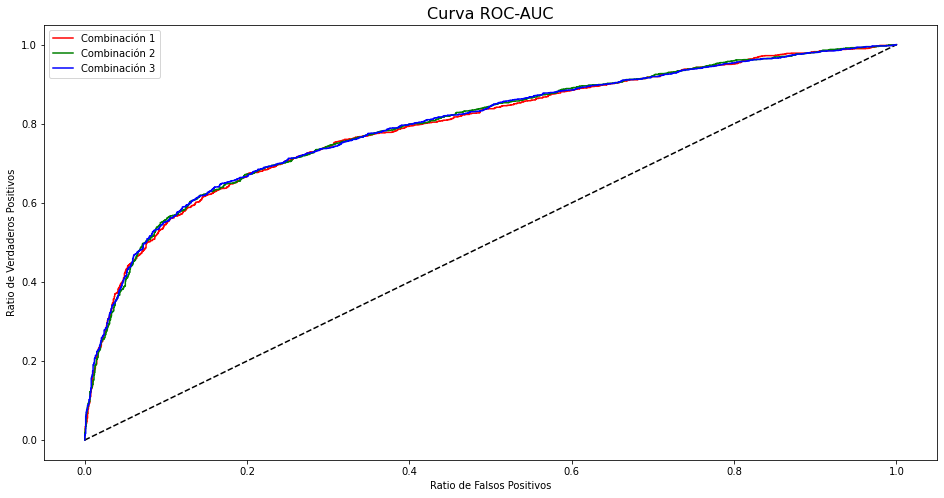

In [79]:
plt.figure(figsize=(16, 8))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_2a, tpr_2a, label='Combinación 1',color = "r")
plt.plot(fpr_2b, tpr_2b, label='Combinación 2',color = "g")
plt.plot(fpr_2c, tpr_2c, label='Combinación 3',color = "b")
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('Curva ROC-AUC',fontsize=16)
plt.legend()
plt.show()

Con respecto a la curva ROC-AUC no se puede visualizar una clara diferencia entre las curvas de la combinación 2 y 3, sin embargo, se puede observar que la curva de la primera combinación parece estar por debajo en comparación con el de las demás combinaciones, lo cual nos dice que no tiene un buen ratio comparándola con las demás al momento de clasificar una muestra con la clase que le corresponde (VP, FP).

In [80]:
print("AUC primera comb.: %.2f%%" % (auc_2a * 100.0))
print("AUC segunda comb.: %.2f%%" % (auc_2b * 100.0))
print("AUC tercera comb.: %.2f%%" % (auc_2c * 100.0))

AUC primera comb.: 73.36%
AUC segunda comb.: 73.40%
AUC tercera comb.: 73.61%


Por último, con un valor porcentual de la métrica de la curva, podemos tomar una decisión final respecto a que combinación elegir. Tomar esta decisión no será muy difícil, ya que en 3 de las 4 pruebas de evaluación observamos claramente que la tercera combinación es la que presentó mejores resultados en comparación con las demás combinaciones, aunque la diferencia entre estas sea porcentual, es por ello que el modelo construido con esta combinación será usado como referente del conjunto de "Hiperparametros para datos con outliers y con codificación manual".

* ### Hiperparámetros para datos sin outliers y sin codificación manual

In [ ]:
def objective(trial):   

    params = {"iterations": trial.suggest_int("iterations",300,1200,100),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
              "depth": trial.suggest_int("depth", 4, 12, 1),
              "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 10),
              "random_strength":trial.suggest_int("random_strength", 0, 40, 1),
              "bagging_temperature": trial.suggest_int("bagging_temperature", 0, 2, 1),
              'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 10),
              "auto_class_weights": "Balanced",
              "loss_function": "Logloss",
              "eval_metric": "AUC",
              "task_type": "GPU",
              "od_type" : "Iter",
              "od_wait" : 30,
              "use_best_model": True,
              "random_seed": 42}
    
    # Identificación de variables categoricas
    categorical_features_indices = np.where(data2.dtypes == np.object)[0]
    
    train_pool = Pool(X2_train, y2_train, cat_features = categorical_features_indices)
    test_pool = Pool(X2_test, y2_test, cat_features = categorical_features_indices)
    
    # Inicialización y entrenamiento del modelo
    model = CatBoostClassifier(**params) 
    model.fit(train_pool, eval_set=test_pool, verbose=True)
    
    # Evaluación y obtención de métricas
    preds = model.predict(X2_test)
    metric = accuracy_score(y2_test, preds)
    
    return metric

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

In [ ]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))
best_3 = study.trials_dataframe()

Se ejecutó la función tres veces de forma independiente, y posterior a ello, se registró la mejor combinación de parámetros que arrojó cada ejecución, siendo estas las siguientes:

* 75.84% | iterarions=900, learning_rate=0.118849, depth=7, l2_leaf_reg=9.48661, random_strength=15, bagging_temperature=1, max_ctr_complexity=6
* 75.72% | iterarions=1000, learning_rate=0.115247, depth=10, l2_leaf_reg=7.87387, random_strength=19, bagging_temperature=1, max_ctr_complexity=6
* 75.66% | iterarions=700, learning_rate=0.0431437, depth=10, l2_leaf_reg=7.91287, random_strength=14, bagging_temperature=0, max_ctr_complexity=4

Procederemos a entrenar modelos CatBoost en base a estas tres combinaciones de hiperparámetros obtenidas para determinar cuál de ellas presenta mejores resultados al clasificar nuestros datos.

#### Identificación de variables categóricas

In [81]:
categorical_features_indices3 = np.where(data2.dtypes == np.object)[0]
train_pool3 = Pool(X2_train, y2_train, cat_features = categorical_features_indices3)
test_pool3 = Pool(X2_test, y2_test, cat_features = categorical_features_indices3)

#### Para la primera combinación

In [82]:
cb_3a = CatBoostClassifier(iterations=900, learning_rate=0.118849, depth=7, l2_leaf_reg=9.48661, random_strength=15,
                            bagging_temperature=1, max_ctr_complexity= 6, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_3a.fit(train_pool3, eval_set = test_pool3, logging_level="Silent")
y_pred_3a = cb_3a.predict(X2_test)

#### Para la segunda combinación

In [83]:
cb_3b = CatBoostClassifier(iterations=1000, learning_rate=0.115247, depth=10, l2_leaf_reg=7.87387, random_strength=19,
                            bagging_temperature=1,  max_ctr_complexity= 6, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_3b.fit(train_pool3, eval_set = test_pool3, logging_level="Silent")
y_pred_3b = cb_3b.predict(X2_test)

#### Para la tercera combinación

In [84]:
cb_3c = CatBoostClassifier(iterations=700, learning_rate=0.0431437, depth=10, l2_leaf_reg=7.91287, random_strength=14,
                            bagging_temperature=0, max_ctr_complexity= 4, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_3c.fit(train_pool3, eval_set = test_pool3, logging_level="Silent")
y_pred_3c = cb_3c.predict(X2_test)

#### Comparación de rendimiento entre combinaciones

#### Para la primera combinación

In [85]:
f1_3a = f1_score(y2_test, y_pred_3a)
acc_3a = accuracy_score(y2_test, y_pred_3a)
auc_3a = roc_auc_score(y2_test, y_pred_3a)
report_3a = classification_report(y2_test,y_pred_3a)

#### Para la segunda combinación

In [86]:
f1_3b = f1_score(y2_test, y_pred_3b)
acc_3b = accuracy_score(y2_test, y_pred_3b)
auc_3b = roc_auc_score(y2_test, y_pred_3b)
report_3b = classification_report(y2_test,y_pred_3b)

#### Para la tercera combinación

In [87]:
f1_3c = f1_score(y2_test, y_pred_3c)
acc_3c = accuracy_score(y2_test, y_pred_3c)
auc_3c = roc_auc_score(y2_test, y_pred_3c)
report_3c = classification_report(y2_test,y_pred_3c)

In [88]:
print("F1 primera comb.: %.2f%%" % (f1_3a * 100.0))
print("Accuracy primera comb.: %.2f%%" % (acc_3a * 100.0))
print("-------------------------------")
print("F1 segunda comb.: %.2f%%" % (f1_3b * 100.0))
print("Accuracy segunda comb.: %.2f%%" % (acc_3b * 100.0))
print("-------------------------------")
print("F1 tercera comb.: %.2f%%" % (f1_3c * 100.0))
print("Accuracy tercera comb.: %.2f%%" % (acc_3c * 100.0))

F1 primera comb.: 70.59%
Accuracy primera comb.: 75.22%
-------------------------------
F1 segunda comb.: 71.21%
Accuracy segunda comb.: 75.25%
-------------------------------
F1 tercera comb.: 71.03%
Accuracy tercera comb.: 75.66%


In [89]:
print(report_3a)
print("-------------------------------------------------")
print(report_3b)
print("-------------------------------------------------")
print(report_3c)

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      1784
           1       0.79      0.64      0.71      1565

    accuracy                           0.75      3349
   macro avg       0.76      0.75      0.75      3349
weighted avg       0.76      0.75      0.75      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      1784
           1       0.78      0.65      0.71      1565

    accuracy                           0.75      3349
   macro avg       0.76      0.75      0.75      3349
weighted avg       0.76      0.75      0.75      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1784
           1       0.80      0.64      0.71      1565

    accuracy                           0.76      3349
   macro avg       0.77     

Observamos que la primera combinación tiene un rendimiento inferior en comparación con las demás combinaciones, y que existe mucha similitud entre los puntajes obtenidos por las combinaciones 2 y 3, donde la combinación que sobresale en comparación con la otra en puntaje F1, no lo hace en Accuracy, y la que lo hace en Accuracy, no lo hace en F1, es por ello que necesitamos más indicios (métricas de evaluación) que nos indiquen que combinación se adapta mejor a nuestros datos.

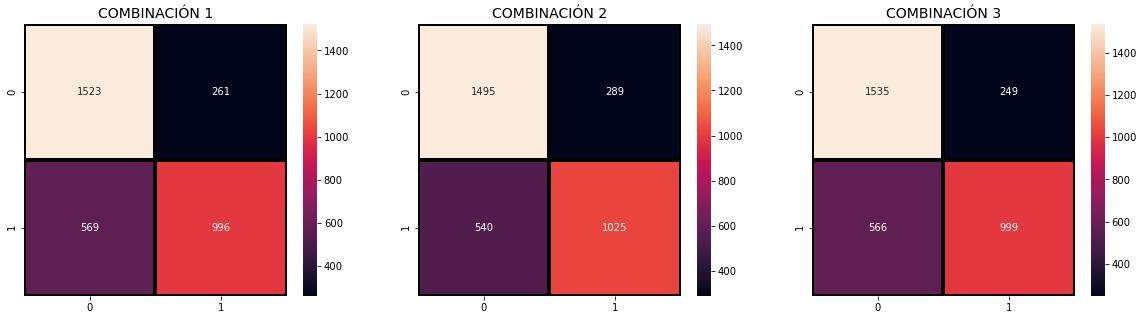

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(confusion_matrix(y2_test, y_pred_3a), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[0])
ax[0].set_title("COMBINACIÓN 1",fontsize=14)

sns.heatmap(confusion_matrix(y2_test, y_pred_3b), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[1])
ax[1].set_title("COMBINACIÓN 2",fontsize=14)

sns.heatmap(confusion_matrix(y2_test, y_pred_3c), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[2])
ax[2].set_title("COMBINACIÓN 3",fontsize=14)

plt.show()

De las matrices de confusión observamos que la segunda combinación es el que mejor ratio en VP tiene, sin embargo, es muy inferior en comparación con las demás combinaciones con respecto a los FP. Un comportamiento similar se observa en la tercera combinación, donde la situación es la misma pero invertida, donde el mejor ratio de predicción se lo llevan los FP y el peor los VP. Sin embargo, ya que su ratio de VP es ligeramente mayor al de la primera combinación, e inferior al de la segunda combinación, podemos decir que se encuentra en término medio, y esto en conjunto con su indiscutible superioridad en la predicción de FP, lo hace un modelo mejor en comparación con los demás, es por ello que en el área de las matrices de confusión preferimos eta combinación.

In [91]:
y_pred_prob3a = cb_3a.predict_proba(X2_test)[:,1]
fpr_3a, tpr_3a, thresholds_3a = roc_curve(y2_test, y_pred_prob3a)
y_pred_prob3b = cb_3b.predict_proba(X2_test)[:,1]
fpr_3b, tpr_3b, thresholds_3b = roc_curve(y2_test, y_pred_prob3b)
y_pred_prob3c = cb_3c.predict_proba(X2_test)[:,1]
fpr_3c, tpr_3c, thresholds_3c = roc_curve(y2_test, y_pred_prob3c)

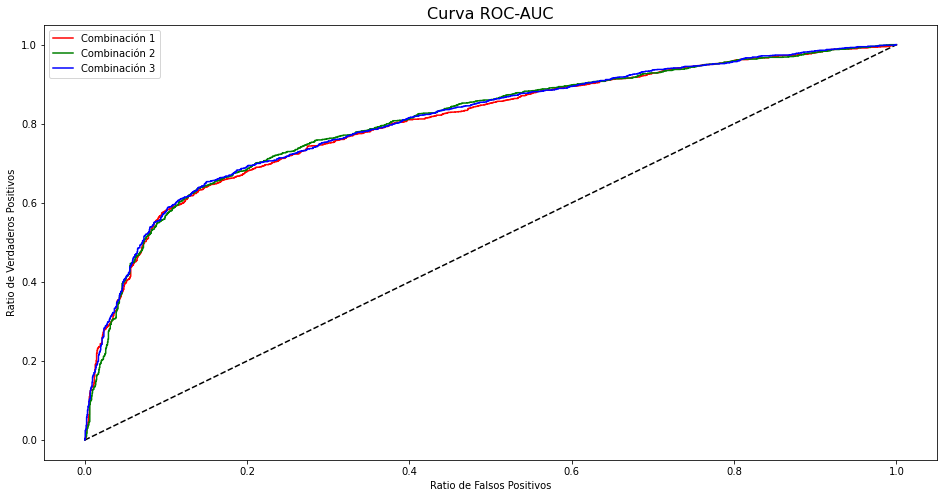

In [92]:
plt.figure(figsize=(16, 8))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_3a, tpr_3a, label='Combinación 1',color = "r")
plt.plot(fpr_3b, tpr_3b, label='Combinación 2',color = "g")
plt.plot(fpr_3c, tpr_3c, label='Combinación 3',color = "b")
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('Curva ROC-AUC',fontsize=16)
plt.legend()
plt.show()

Con respecto a la curva ROC-AUC podemos identificar que aparentemente las combinaciones 2 y 3 son las que presentan un mejor ratio en VP y FP, sin embargo, la diferencia entre estas no es tan clara, puesto que hay momentos en donde presentan una inclinación similar, y otros en donde una muestra superioridad sobre la otra, es por ello que calcularemos el valor de su métrica con el fin de poder tener una mejor interpretabilidad.

In [93]:
print("AUC primera comb.: %.2f%%" % (auc_3a * 100.0))
print("AUC segunda comb.: %.2f%%" % (auc_3b * 100.0))
print("AUC tercera comb.: %.2f%%" % (auc_3c * 100.0))

AUC primera comb.: 74.51%
AUC segunda comb.: 74.65%
AUC tercera comb.: 74.94%


Con esto último, observamos que el mejor valor AUC se lo lleva la tercera combinación, el peor valor la primera combinación, y en término medio se encuentra la segunda combinación. No obstante, la diferencia entre estos valores es muy pequeña, por lo cual no podemos decir que una combinación es mucho más efectiva que otra. Entonces, uniendo los resultados de todas las métricas vistas, podemos considerar a todas las combinaciones como buenas, ya que no existe una gran diferencia en efectividad de predicción entre ellas, sin embargo, en esta ocasión elegiremos la tercera combinación como ganadora, ya que es la que presenta un equilibrio entre predecir correctamente aquellas muestras que son positivas (depósito a plazo fijo) y negativas (no depósito a plazo fijo), por lo tanto, utilizaremos el modelo construido con esta combinación como referente del conjunto de "Hiperparametros para datos sin outliers y sin codificación manual".

* ### Hiperparámetros para datos sin outliers y con codificación manual

In [ ]:
def objective(trial):   

    params = {"iterations": trial.suggest_int("iterations",300,1200,100),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
              "depth": trial.suggest_int("depth", 4, 12, 1),
              "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 10),
              "random_strength":trial.suggest_int("random_strength", 0, 40, 1),
              "bagging_temperature": trial.suggest_int("bagging_temperature", 0, 2, 1),
              'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 10),
              "auto_class_weights": "Balanced",
              "loss_function": "Logloss",
              "eval_metric": "AUC",
              "task_type": "GPU",
              "od_type" : "Iter",
              "od_wait" : 30,
              "use_best_model": True,
              "random_seed": 42}
    
    train_pool = Pool(X2_train_cod, y2_train_cod)
    test_pool = Pool(X2_test_cod, y2_test_cod)
    
    # Inicialización y entrenamiento del modelo
    model = CatBoostClassifier(**params) 
    model.fit(train_pool, eval_set=test_pool, verbose=True)
    
    # Evaluación y obtención de métricas
    preds = model.predict(X2_test_cod)
    metric = accuracy_score(y2_test_cod, preds)
    
    return metric

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

In [ ]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))
best_4 = study.trials_dataframe()

Se ejecutó la función tres veces de forma independiente, y posterior a ello, se registró la mejor combinación de parámetros que arrojó cada ejecución, siendo estas las siguientes:

* 75.24% | iterarions=600, learning_rate=0.0856975, depth=9, l2_leaf_reg=7.42101, random_strength=0, bagging_temperature=0, max_ctr_complexity=10
* 75.18% | iterarions=1200, learning_rate=0.0274008, depth=10, l2_leaf_reg=7.42817, random_strength=0, bagging_temperature=1, max_ctr_complexity=1
* 75.15% | iterarions=700, learning_rate=0.0854912, depth=10, l2_leaf_reg=5.43813, random_strength=0, bagging_temperature=0, max_ctr_complexity=10

Procederemos a entrenar modelos CatBoost en base a estas tres combinaciones de hiperparámetros obtenidas para determinar cuál de ellas presenta mejores resultados al clasificar nuestros datos.

In [94]:
train_pool4 = Pool(X2_train_cod, y2_train_cod)
test_pool4 = Pool(X2_test_cod, y2_test_cod)

#### Para la primera combinación

In [95]:
cb_4a = CatBoostClassifier(iterations=600, learning_rate=0.0856975, depth=9, l2_leaf_reg=7.42101, random_strength=0,
                            bagging_temperature=0, max_ctr_complexity=10, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_4a.fit(train_pool4, eval_set = test_pool4, logging_level="Silent")
y_pred_4a = cb_4a.predict(X2_test_cod)

#### Para la segunda combinación

In [96]:
cb_4b = CatBoostClassifier(iterations=1200, learning_rate=0.0274008, depth=10, l2_leaf_reg=7.42817, random_strength=0,
                            bagging_temperature=1,  max_ctr_complexity=1, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_4b.fit(train_pool4, eval_set = test_pool4, logging_level="Silent")
y_pred_4b = cb_4b.predict(X2_test_cod)

#### Para la tercera combinación

In [97]:
cb_4c = CatBoostClassifier(iterations=700, learning_rate=0.0854912, depth=10, l2_leaf_reg=5.43813, random_strength=0,
                            bagging_temperature=0, max_ctr_complexity=10, auto_class_weights= "Balanced", loss_function = "Logloss",
                            eval_metric = "AUC", task_type= "GPU", use_best_model= True, random_seed=42)

cb_4c.fit(train_pool4, eval_set = test_pool4, logging_level="Silent")
y_pred_4c = cb_4c.predict(X2_test_cod)

#### Comparación de rendimiento entre combinaciones

#### Para la primera combinación

In [98]:
f1_4a = f1_score(y2_test_cod, y_pred_4a)
acc_4a = accuracy_score(y2_test_cod, y_pred_4a)
auc_4a = roc_auc_score(y2_test_cod, y_pred_4a)
report_4a = classification_report(y2_test_cod,y_pred_4a)

#### Para la segunda combinación

In [99]:
f1_4b = f1_score(y2_test_cod, y_pred_4b)
acc_4b = accuracy_score(y2_test_cod, y_pred_4b)
auc_4b = roc_auc_score(y2_test_cod, y_pred_4b)
report_4b = classification_report(y2_test_cod,y_pred_4b)

#### Para la tercera combinación

In [100]:
f1_4c = f1_score(y2_test_cod, y_pred_4c)
acc_4c = accuracy_score(y2_test_cod, y_pred_4c)
auc_4c = roc_auc_score(y2_test_cod, y_pred_4c)
report_4c = classification_report(y2_test_cod,y_pred_4c)

In [101]:
print("F1 primera comb.: %.2f%%" % (f1_4a * 100.0))
print("Accuracy primera comb.: %.2f%%" % (acc_4a * 100.0))
print("-------------------------------")
print("F1 segunda comb.: %.2f%%" % (f1_4b * 100.0))
print("Accuracy segunda comb.: %.2f%%" % (acc_4b * 100.0))
print("-------------------------------")
print("F1 tercera comb.: %.2f%%" % (f1_4c * 100.0))
print("Accuracy tercera comb.: %.2f%%" % (acc_4c * 100.0))

F1 primera comb.: 71.56%
Accuracy primera comb.: 75.25%
-------------------------------
F1 segunda comb.: 71.53%
Accuracy segunda comb.: 75.19%
-------------------------------
F1 tercera comb.: 71.53%
Accuracy tercera comb.: 75.16%


In [102]:
print(report_4a)
print("-------------------------------------------------")
print(report_4b)
print("-------------------------------------------------")
print(report_4c)

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1784
           1       0.77      0.67      0.72      1565

    accuracy                           0.75      3349
   macro avg       0.76      0.75      0.75      3349
weighted avg       0.75      0.75      0.75      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1784
           1       0.77      0.67      0.72      1565

    accuracy                           0.75      3349
   macro avg       0.75      0.75      0.75      3349
weighted avg       0.75      0.75      0.75      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1784
           1       0.77      0.67      0.72      1565

    accuracy                           0.75      3349
   macro avg       0.75     

Respecto a esta combinación de métricas se observa claramente que la primera combinación es la que mejores resultados presenta, aunque la diferencia de sus puntajes comparados con el de las demás combinaciones sea relativamente pequeña.

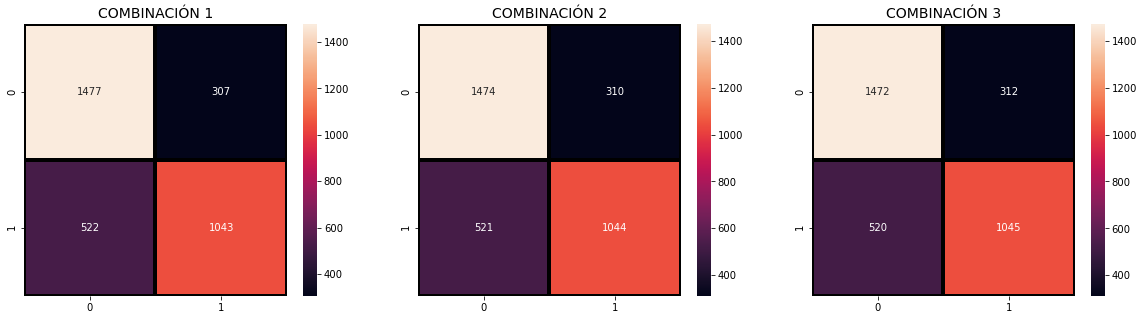

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(confusion_matrix(y2_test_cod, y_pred_4a), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[0])
ax[0].set_title("COMBINACIÓN 1",fontsize=14)

sns.heatmap(confusion_matrix(y2_test_cod, y_pred_4b), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[1])
ax[1].set_title("COMBINACIÓN 2",fontsize=14)

sns.heatmap(confusion_matrix(y2_test_cod, y_pred_4c), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[2])
ax[2].set_title("COMBINACIÓN 3",fontsize=14)

plt.show()

De las matrices de confusión observamos que todas las combinaciones tienen resultados muy similares los unos con los otros, por lo tanto, es difícil decidir en este apartado de evaluación que combinación resulta más efectiva en la predicción clientes solicitantes y no solicitantes de un depósito a plazo fijo.

In [104]:
y_pred_prob4a = cb_4a.predict_proba(X2_test_cod)[:,1]
fpr_4a, tpr_4a, thresholds_4a = roc_curve(y2_test_cod, y_pred_prob4a)
y_pred_prob4b = cb_4b.predict_proba(X2_test_cod)[:,1]
fpr_4b, tpr_4b, thresholds_4b = roc_curve(y2_test_cod, y_pred_prob4b)
y_pred_prob4c = cb_4c.predict_proba(X2_test_cod)[:,1]
fpr_4c, tpr_4c, thresholds_4c = roc_curve(y2_test_cod, y_pred_prob4c)

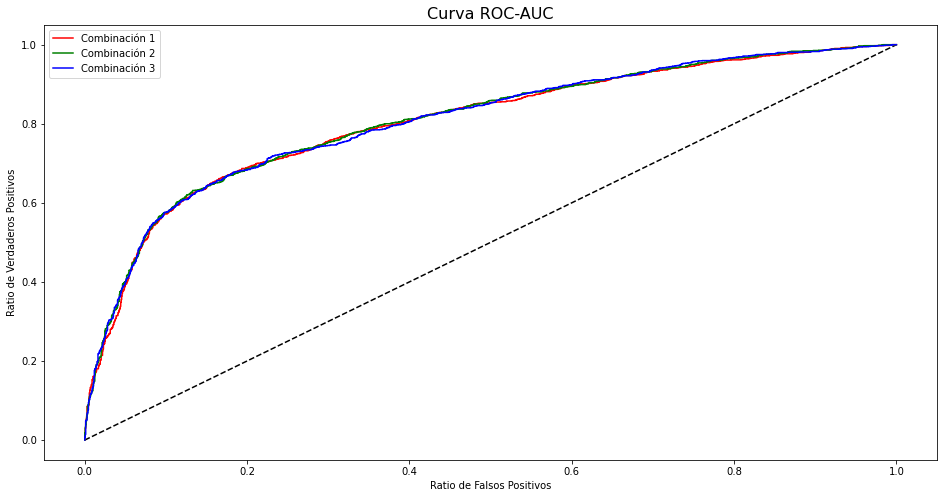

In [105]:
plt.figure(figsize=(16, 8))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_4a, tpr_4a, label='Combinación 1',color = "r")
plt.plot(fpr_4b, tpr_4b, label='Combinación 2',color = "g")
plt.plot(fpr_4c, tpr_4c, label='Combinación 3',color = "b")
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('Curva ROC-AUC',fontsize=16)
plt.legend()
plt.show()

Con respecto a la curva ROC-AUC, no podemos identificar claramente que combinación es superior a las demás, ya que existen algunos trazos en los que una combinación es inferior a otra, y otros en los que es superior a las demás, es por ello que calcularemos el valor de su métrica con el fin de poder tener una mejor interpretabilidad.

In [106]:
print("AUC primera comb.: %.2f%%" % (auc_4a * 100.0))
print("AUC segunda comb.: %.2f%%" % (auc_4b * 100.0))
print("AUC tercera comb.: %.2f%%" % (auc_4c * 100.0))

AUC primera comb.: 74.72%
AUC segunda comb.: 74.67%
AUC tercera comb.: 74.64%


Estos resultados indican que la primera combinación posee un mejor ratio en la correcta predicción de nuestros datos, sin embargo, cabe recalcar que la diferencia de este valor comparado con el de las demás combinaciones es muy pequeña, es por ello que elegir cualquiera de estas combinaciones presentadas sería una opción correcta, ya que todas tienen un rendimiento muy similar. Para este caso, basándonos en la diferencia porcentual de valores de métrica ya vistos, elegiremos el modelo construido con la primera combinación como el que mejor clasifica nuestros datos, por lo tanto, será usado como referente del conjunto de "Hiperparametros para datos sin outliers y con codificación manual".

### Elección del mejor modelo

Después de haber elegido las cuatro mejores combinaciones en base al entrenamiento de conjuntos con diferentes tipos de transformación y codificación, procederemos a compararlos entre sí para quedarnos con un modelo definitivo el cual mejores resultados de evaluación tenga.

In [107]:
print("F1 Primer conjunto: %.2f%%" % (f1_1b * 100.0))
print("Accuracy Primer conjunto: %.2f%%" % (acc_1b * 100.0))
print("-------------------------------")
print("F1 Segundo conjunto: %.2f%%" % (f1_2c * 100.0))
print("Accuracy Segundo conjunto: %.2f%%" % (acc_2c * 100.0))
print("-------------------------------")
print("F1 Tercer conjunto: %.2f%%" % (f1_3c * 100.0))
print("Accuracy Tercer conjunto: %.2f%%" % (acc_3c * 100.0))
print("-------------------------------")
print("F1 Cuarto conjunto: %.2f%%" % (f1_4a * 100.0))
print("Accuracy Cuarto conjunto: %.2f%%" % (acc_4a * 100.0))

F1 Primer conjunto: 69.63%
Accuracy Primer conjunto: 73.90%
-------------------------------
F1 Segundo conjunto: 70.72%
Accuracy Segundo conjunto: 73.99%
-------------------------------
F1 Tercer conjunto: 71.03%
Accuracy Tercer conjunto: 75.66%
-------------------------------
F1 Cuarto conjunto: 71.56%
Accuracy Cuarto conjunto: 75.25%


In [108]:
print(report_1b)
print("-------------------------------------------------")
print(report_2c)
print("-------------------------------------------------")
print(report_3c)
print("-------------------------------------------------")
print(report_4a)

              precision    recall  f1-score   support

           0       0.72      0.84      0.77      1762
           1       0.78      0.63      0.70      1587

    accuracy                           0.74      3349
   macro avg       0.75      0.73      0.73      3349
weighted avg       0.74      0.74      0.74      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1762
           1       0.76      0.66      0.71      1587

    accuracy                           0.74      3349
   macro avg       0.74      0.74      0.74      3349
weighted avg       0.74      0.74      0.74      3349

-------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1784
           1       0.80      0.64      0.71      1565

    accuracy                           0.76      3349
   macro avg       0.77     

En principio observamos que el modelo construido con el tercer conjunto (Datos sin outliers y sin codificación manual) presenta un rendimiento superior en cuanto a Accuracy se refiere, sin embargo, en cuanto a puntaje F1, es inferior al modelo construido con el cuarto conjunto (Datos sin outliers y con codificación manual). Los conjuntos de datos que si presentan outliers parecen tener un rendimiento inferior en comparación de los conjuntos a los cuales si se les realizo un tratamiento de estos valores.

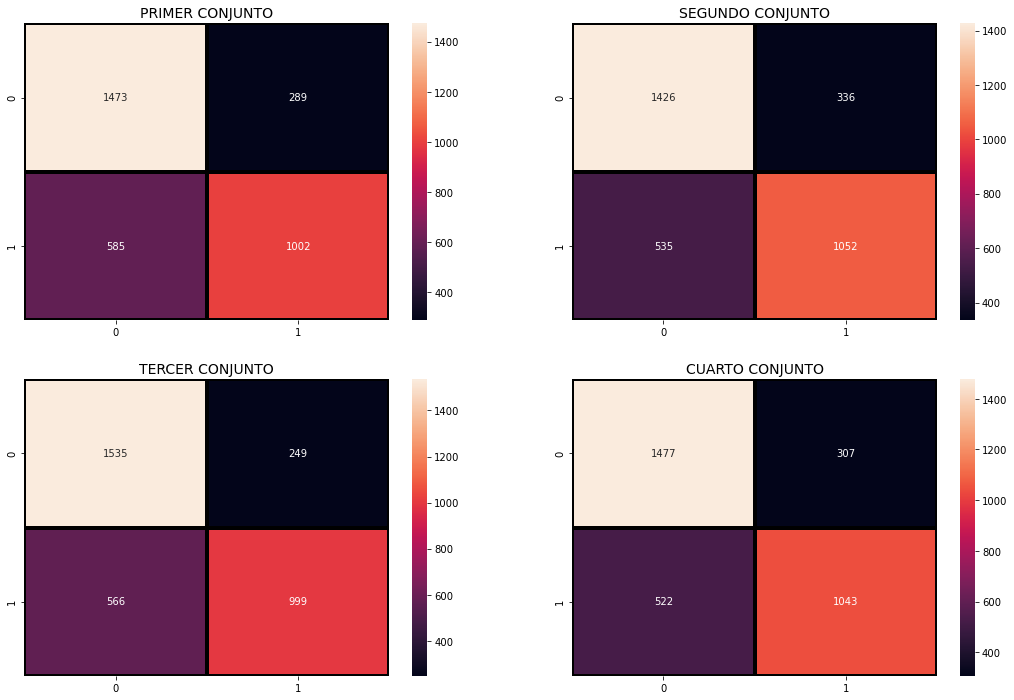

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

sns.heatmap(confusion_matrix(y_test, y_pred_1b), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[0,0])
ax[0][0].set_title("PRIMER CONJUNTO",fontsize=14)

sns.heatmap(confusion_matrix(y_test_cod, y_pred_2c), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[0,1])
ax[0][1].set_title("SEGUNDO CONJUNTO",fontsize=14)

sns.heatmap(confusion_matrix(y2_test, y_pred_3c), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[1,0])
ax[1][0].set_title("TERCER CONJUNTO",fontsize=14)

sns.heatmap(confusion_matrix(y2_test_cod, y_pred_4a), annot=True, fmt = "d", linecolor="k", linewidths=3, ax=ax[1,1])
ax[1][1].set_title("CUARTO CONJUNTO",fontsize=14)

plt.show()

Las matrices de confusión nos dejan ver que la competencia en la elección del mejor modelo predictivo se encuentra entre los modelos construidos con el tercer y cuarto conjunto (Datos sin outliers), ya que presentan superioridad predictora en comparación con los modelos construidos con el primer y segundo conjunto (Datos con outliers). En cuanto al tercer conjunto, podemos observar que su punto fuerte es la predicción de muestras catalogadas con clase negativa (0), y en cuanto al cuarto conjunto, su punto fuerte es la predicción de muestras catalogadas con clase positiva (1). Dependiendo de las necesidades de la empresa en tomar más atención a aquellos clientes que soliciten o no soliciten un depósito a plazo fijo, se podría elegir cualquier de estos dos modelos como valido.

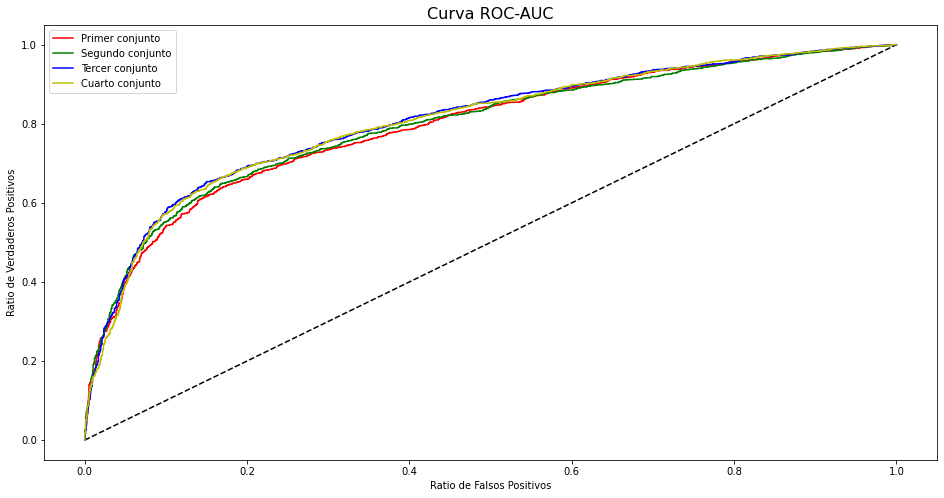

In [110]:
plt.figure(figsize=(16, 8))
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_1b, tpr_1b, label='Primer conjunto',color = "r")
plt.plot(fpr_2c, tpr_2c, label='Segundo conjunto',color = "g")
plt.plot(fpr_3c, tpr_3c, label='Tercer conjunto',color = "b")
plt.plot(fpr_4a, tpr_4a, label='Cuarto conjunto',color = "y")
plt.xlabel('Ratio de Falsos Positivos')
plt.ylabel('Ratio de Verdaderos Positivos')
plt.title('Curva ROC-AUC',fontsize=16)
plt.legend()
plt.show()

Con respecto a la curva ROC-AUC, observamos una clara similitud entre los modelos construidos con el tercer y cuarto conjunto, como anteriormente habíamos visto, estos modelos presentan superioridad predictiva en comparación con los construidos por el primer y segundo conjunto, lo cual nos da más motivos para ir concluyendo que estos modelos no serán elegidos como definitivos. Para poder tener una visión más clara acerca de qué conjunto (tercero o cuarto) presenta una mejor sensibilidad predictora, calcularemos el valor de la métrica AUC.

In [111]:
print("AUC Primer conjunto: %.2f%%" % (auc_1b * 100.0))
print("AUC Segundo conjunto: %.2f%%" % (auc_2c * 100.0))
print("AUC Tercer conjunto: %.2f%%" % (auc_3c * 100.0))
print("AUC Cuarto conjunto: %.2f%%" % (auc_4a * 100.0))

AUC Primer conjunto: 73.37%
AUC Segundo conjunto: 73.61%
AUC Tercer conjunto: 74.94%
AUC Cuarto conjunto: 74.72%


Estos resultados indican que el modelo construido con el tercer conjunto presenta un ratio mayor en la predicción de VP y FP en comparación con los demás conjuntos, aunque la diferencia entre este conjunto y el cuarto es mínima. Entonces, uniendo los resultados de las demás métricas de evaluación anteriormente vistas, podemos llegas a concluir que tanto el modelo construido con el tercer conjunto como con el cuarto, son completamente válidos para ser considerados como definitivos, y que su elección depende mucho del objetivo que tenga el cliente o la empresa en cuanto a que clase necesita enfocar la predicción. En esta ocasión, tomaremos el modelo construido con el tercer conjunto como definitivo, ya que presenta una ligera superioridad en cuanto a AUC Y Accuracy en comparación con los demás modelos.

Combinacion de parametros del modelo final:

* iterarions=700, learning_rate=0.0431437, depth=10, l2_leaf_reg=7.91287, random_strength=14, bagging_temperature=0, max_ctr_complexity=4

In [112]:
# Guardado del modelo
joblib.dump(cb_3c, "CatBoost_Model_BankMarketing")

['CatBoost_Model_BankMarketing']

### Interpretación del modelo

Esta sección estará dedicada a entender como las variables y los posibles valores que estas tomen afectan en la decisión del modelo sobre clasificar a un cliente como solicitante o no solicitante de un depósito a plazo fijo. Para ello, haremos uso de la función de extracción de importancia de características implementada por CatBoost, y de los valores SHAP basados en la teoría de juegos.

#### Importancia de características de Catboost

In [113]:
columns = data2.iloc[:,:-1].columns.values  # Extracción de los nombres de las variables independientes

pd.DataFrame({'Importancia': cb_3c.get_feature_importance(), 'Variable': columns}).sort_values(by=['Importancia'],
                                                                                               ascending=False)

,Importancia,Variable
10,23.626209,month
13,18.144004,poutcome
8,10.616032,contact
9,7.899571,day
1,6.762166,job
6,6.712150,housing
5,6.606008,balance
3,5.423614,education
2,4.800723,marital
0,4.572285,age


El marco de datos obtenido nos dice que la variable "month" tiene un papel fundamental en la clasificación de una muestra como solicitante o no solicitante de un depósito a plazo fijo. Esto tiene sentido, ya que en la sección del análisis de datos habíamos observado que existían algunos meses en los que era muy probable que el cliente aceptase solicitar este tipo de depósito (marzo, septiembre, octubre y diciembre) y otros en los que no (mayo). Por otra parte, también observamos que variables como "poutcome" y "contact" juegan un papel crucial en dicha predicción, puesto que aquellos clientes que habían solicitado este depósito en la campaña anterior, con mucha probabilidad volverían a solicitarlo en la campaña actual, mientras que aquellos cuyo medio de contacto era desconocido por el banco, tenían menos probabilidades de solicitar este depósito. A la vez que también se puede apreciar que variables como "default" (mora crediticia con el banco) o "previous" (número de contactos realizados en la anterior campaña) aportan poco en la decisión final del modelo.

#### Valores SHAP

In [114]:
X2_train_shap = pd.DataFrame(X2_train)  # Conversión del conjunto de entrenamiento en Dataframe
X2_train_shap.columns = columns  # Extracción de los nombres de las variables independientes

# Codificación del tipo de variable de Object a Int
X2_train_shap[["age", "balance", "day", "campaign", "previous"]] = X2_train_shap[["age", "balance", "day", "campaign",
                                                                                  "previous"]].astype(int)

In [115]:
shap_values = cb_3c.get_feature_importance(train_pool3, type='ShapValues')  # Calculo de los valores SHAP 
expected_value = shap_values[0,-1]  # Extracción de los valores SHAP de la columna dependiente
shap_values = shap_values[:,:-1]  # Extracción de los valores SHAP de las columnas independientes

Empezaremos por calcular los valores SHAP para las variables de una muestra determinada en nuestro conjunto de datos.

In [117]:
shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X2_train_shap.iloc[0,:])

Observamos que la probabilidad de que un cliente solicite un depósito a plazo fijo aumenta para esta muestra cuando su ocupación (job) es ser estudiante, se le contacto en el mes de mayo (month), el tipo de contacto realizado fue por celular (contact) y solicito este mismo servicio en la campaña anterior (poutcome), mientras que sus probabilidades decrecen si es que este solicito un préstamo de vivienda (housing). Estos hechos respaldan los insights que habíamos obtenido en la sección de análisis de datos, donde pudimos identificar que los clientes que eran estudiantes o jubilados eran propensos a solicitar este depósito, a la vez que si estos habían aceptado solicitar este servicio en la campaña anterior, con mucha probabilidad volverían a hacerlo en la campaña actual, es por ello que en el gráfico, "poutcome = success" tiene un mayor impacto en el impulso del modelo hacia predecir a este cliente como solicitante de un depósito a plazo fijo. Mientras que por su parte, "housing = yes", tiene un impulso para predecir a este cliente como no solicitante de este tipo de depósito.

In [118]:
shap.force_plot(expected_value, shap_values[100,:], X2_train_shap.iloc[100,:])

Por otra parte, en este ejemplo observamos que existen muchas más variables con valores que propician al modelo a tomar la decisión de que cliente no será solicitante de un depósito a plazo fijo, ya que volviendo a recalcar, como anteriormente habíamos visto en la sección de análisis de datos, cuando el tipo de contacto que se tenía con el cliente era desconocido por el banco, o cuando no se tenía información acerca si este había aceptado solicitar este tipo de depósito en la campaña anterior, sus probabilidades de aceptar solicitar el depósito en la campaña actual se veían reducidas, es por ello que este comportamiento se ve reflejado en el gráfico de SHAP mediante barras color azul en dirección a la izquierda.

In [119]:
shap.force_plot(expected_value, shap_values[1000,:], X2_train_shap.iloc[1000,:])

Esta muestra presenta un comportamiento similar al de la primera, en donde aquellas variables que impulsan al modelo a tomar la decisión de clasificar a este cliente como solicitante de un depósito a plazo fijo son "poutcome", "contact", "month" y "job", cuando estas adquieren un valor de "succes", "cellular", "may" y "blue-collar" respectivamente. Mientras que las variables que impulsan al modelo a tomar la decisión de clasificarlo como no solicitante son "housing" y "campaign", cuando estas adquieren un valor de "yes" y "6" respectivamente. Algunos de estos valores pueden dar la ilusión de contradecir los análisis anteriormente vistos, como en el caso de "month = may" donde pudimos observar que en este mes habían más posibilidades de que el cliente no aceptara solicitar este tipo de depósito, sin embargo, debido a que estamos hablando de posibilidad y no de hechos, se asume que aunque exista una alta de probabilidad de rechazar el depósito en este mes, aún existen probabilidades de no hacerlo, es por ello que el grafico se muestra a "month = may" como una variable que influenció (aunque en pequeña medida) a la decisión del modelo a clasificar a este cliente como solicitante de un depósito a plazo fijo.

Por último, graficaremos un resumen general del impacto de los valores que pueden tomar cada una de nuestras variables en la decisión del modelo. Cabe mencionar que actualmente esta gráfica solo funciona para variable numéricas, puesto que son las únicas a las que se le puede asociar valores altos y bajos.

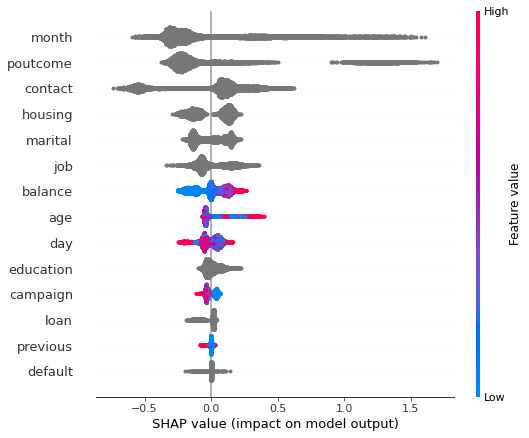

In [120]:
shap.summary_plot(shap_values, X2_train_shap)

Este grafico aparte de mostrar en orden descendente la importancia de cada variable para la predicción del modelo, nos muestra cómo afectan tanto los valores altos como los bajos en su decisión de clasificar a un cliente como solicitante o no solicitante de un depósito a plazo fijo. Donde podemos observar que un saldo (balance) bajo en la cuenta del cliente influye a que el modelo lo catalogue como no solicitante, o que una edad (age) mayor influye a que este lo catalogue como solicitante.

Todos estos gráficos son muy importantes, ya que nos proporcionan insights muy útiles para entender a mayor profundidad el comportamiento o características de los clientes que tienden o no a solicitar el depósito ofrecido por el banco, lo cual, ayudara sin duda a los planes comerciales de la empresa.

---

## 8. Conclusiones

* El hecho de saber si un cliente estuvo afiliado al servicio de depósito a plazo fijo del banco en el pasado ayuda en gran medida a decidir si este volverá a solicitar nuevamente este servicio, ya que se evidenció que aquellos clientes que sí estuvieron afiliados a este tipo de depósito en la campaña anterior, volvieron a solicitarlo en la campaña actual.

* Existe una tendencia en los clientes en solicitar préstamos de vivienda en mayo, lo que causa que en este mes haya menos posibilidades de conseguir que los clientes acepten solicitar este tipo de depósito. Es por ello que se puede recomendar al banco evitar invertir muchos esfuerzos y recursos en la persuasión de clientes en este mes del año, y centrar sus recursos en explotar otros meses de poca actividad como marzo, septiembre, octubre o diciembre, en donde se observó una tendencia de los clientes a solicitar este depósito.

* Se evidencio que el tratamiento de outliers previo a la construcción de un modelo predictivo ayudó a que este obtuviera un rendimiento mucho mejor frente a modelos construidos con datos sin procesamiento previo de este tipo de valores. En donde la técnica utilizada fue la imputación iterativa, aprovechando la potencia de los bosques aleatorios para reemplazar estos valores atípicos por valores que se asemejen a un comportamiento normal en nuestro conjunto de datos.

* Gracias a los valores SHAP, es posible dar una explicación acerca del funcionamiento y la relevancia que tiene cada una de nuestras variables y los posibles valores que puedan tomar en la predicción de modelos de aprendizaje automático de caja negra, aportando información muy útil que puede complementar en gran medida al análisis de datos que se haya realizado con anterioridad, o servir de antesala para nuevos análisis futuros.

---